# Introduction


In this notebook, we delve into the analysis of BBC News data, aiming to uncover insights into the distribution of topics, potential biases, and the categorization of articles.

**Data Source:**
The dataset used in this analysis is scraped from BBC News (bbc.co.uk/news) for 5 continuous days with a historical limit of 3 months.

**Objective:**
Our primary objectives include:
1. <u>**_Identifying Bias_**</u>: We will analyze the dataset to uncover any biases in the distribution of articles across different categories or topics.
   
3. <u>**_Sentiment Analysis_**</u>: A key part of our analysis involves assessing the sentiment of the articles. This will help us understand the tone (positive, negative, or neutral) of the news content.
   
5. <u>**_Trend Analysis_**</u>: We aim to examine trends over time in the news topics. This includes identifying potential patterns, peaks, or declines in topics, providing insight into the evolving focus of news coverage.
   
4. <u>**_Categorization_**</u>: Utilizing natural language processing techniques, we will categorize articles based on their textual content. This involves exploring similarities between articles and clustering them into meaningful groups.
   
5. <u>**__Authors collaboration network__**</u>: We will construct and analyze a network graph depicting collaborations among authors.

# Imports

In [82]:
import pandas as pd
import boto3
import configparser
import os
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import matplotlib.dates as mdates
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import networkx as nx
import itertools
from nltk.sentiment import SentimentIntensityAnalyzer
from scipy.stats import chi2_contingency
from yellowbrick.cluster import SilhouetteVisualizer

# Loading Dataset

During this section we will be gathering data from our s3 bucket and concatenating it into a single source file

In [2]:
parser = configparser.ConfigParser()
parser.read(os.path.join(os.getcwd(), '../../Data_Engineering/config/config.conf'))

aws_access_key = parser.get('aws', 'aws_access_key')
aws_secret_key = parser.get('aws', 'aws_secret_key')
s3_bucket_name = parser.get('aws', 's3_bucket_name')
s3_client = boto3.client('s3', aws_access_key_id=aws_access_key, aws_secret_access_key=aws_secret_key)

In [3]:
def get_available_data(s3_client):
        
        result = set()
        s3_bucket = s3_client.list_objects(Bucket=s3_bucket_name, Prefix="clean-data/")
        
        if "Contents" not in s3_bucket: return result
        
        clean_files = s3_bucket["Contents"]
        for file in clean_files:
            if ".csv" in file["Key"]: result.add(file["Key"])
        
        return result

data = get_available_data(s3_client)
data

{'clean-data/3-Months-Run_BBC_DATA_2024-01-08_cleaned.csv',
 'clean-data/BBC_DATA_2024-01-08_cleaned.csv',
 'clean-data/BBC_DATA_2024-01-09_cleaned.csv',
 'clean-data/BBC_DATA_2024-01-10_cleaned.csv',
 'clean-data/BBC_DATA_2024-01-11_cleaned.csv',
 'clean-data/BBC_DATA_2024-01-12_cleaned.csv'}

In [4]:
def extract_data(s3_client, file_name):
        
        obj = s3_client.get_object(Bucket=s3_bucket_name, Key=file_name)
        csv_string = StringIO(obj['Body'].read().decode('utf-8'))
        df = pd.read_csv(csv_string)
        return df

df = pd.DataFrame()
for file in data:
    tmp_df = extract_data(s3_client, file)
    df = pd.concat([df, tmp_df])

df.head()

uri  \
0  https://www.bbc.com/news/world-middle-east-679...   
1  https://www.bbc.com/news/world-middle-east-679...   
2         https://www.bbc.com/news/uk-wales-62134399   
3     https://www.bbc.com/news/world-africa-67911057   
4     https://www.bbc.com/news/world-africa-67914673   

                                               title  \
0  Al Jazeera bureau chief's son Hamza al-Dahdouh...   
1  Palestinians must be able to stay in Gaza - Bl...   
2  How does the new Wales-wide 20mph speed limit ...   
3  Ethiopia-Somaliland deal makes waves in Horn o...   
4  Betta Edu: Nigerian poverty minister suspended...   

                                            subtitle date_posted  \
0  The eldest son of Al Jazeera's Gaza bureau chi...  2024-01-08   
1  US Secretary of State Antony Blinken says Pale...  2024-01-08   
2  Motorists in Wales now have to limit their spe...  2024-01-08   
3  The defence minister of the self-declared repu...  2024-01-08   
4  Nigeria's president has suspended a minister o...  2024-01-08   

                                           full_text  \
0  The eldest son of Al Jazeera's Gaza bureau chi...   
1  US Secretary of State Antony Blinken says Pale...   
2  Motorists in Wales now have to limit their spe...   
3  The defence minister of the self-declared repu...   
4  Nigeria's president has suspended a minister o...   

                                              topics  \
0        ['Israel-Gaza war', 'Journalism', 'Israel']   
1  ['Israel & the Palestinians', 'Antony Blinken'...   
2  ['Climate', 'Welsh government', 'Environment',...   
3              ['Somalia', 'Somaliland', 'Ethiopia']   
4                                        ['Nigeria']   

                                              images  \
0  ['https://ichef.bbci.co.uk/news/976/cpsprodpb/...   
1  ['https://ichef.bbci.co.uk/news/976/cpsprodpb/...   
2  ['https://ichef.bbci.co.uk/news/976/cpsprodpb/...   
3  ['https://ichef.bbci.co.uk/news/976/cpsprodpb/...   
4  ['https://ichef.bbci.co.uk/news/976/cpsprodpb/...   

                                     authors         category      subcategory  
0                         ['Shaimaa Khalil']  Israel-Gaza war  Israel-Gaza war  
1                          ['George Wright']  Israel-Gaza war  Israel-Gaza war  
2          ['Nicola Bryan', 'Natalie Grice']          Climate   Climate Change  
3                            ['Damian Zane']            World           Africa  
4  ['Mansur Abubakar', 'Wedaeli Chibelushi']            World           Africa

In [5]:
df.shape

(8602, 10)

As we could have some intersection data between the inital first runs, and as we have some duplication due to common topics as categories, we need to drop duplicate data.

In [6]:
df.drop_duplicates(subset=["uri"], inplace=True)

In [7]:
df.shape

(8187, 10)

That being done, we shall proceed to casting our data to the correspondant types to start our analysis

In [8]:
def transform_data(csv_dataframe):
        
        df['uri'] = df['uri'].astype(str)
        df['title'] = df['title'].astype(str)
        df['subtitle'] = df['subtitle'].astype(str)
        df['date_posted'] = pd.to_datetime(df['date_posted'], format='%Y-%m-%d')
        df['full_text'] = df['full_text'].astype(str)
        df['topics'] = df['topics'].apply(lambda record: eval(str(record)))
        df['images'] = df['images'].apply(lambda record: eval(str(record)))
        df['authors'] = df['authors'].apply(lambda record: eval(str(record)))
        df['category'] = df['category'].astype(str)
        df['subcategory'] = df['subcategory'].astype(str)
        
        return df

df = transform_data(df)
df.head()

uri  \
0  https://www.bbc.com/news/world-middle-east-679...   
1  https://www.bbc.com/news/world-middle-east-679...   
2         https://www.bbc.com/news/uk-wales-62134399   
3     https://www.bbc.com/news/world-africa-67911057   
4     https://www.bbc.com/news/world-africa-67914673   

                                               title  \
0  Al Jazeera bureau chief's son Hamza al-Dahdouh...   
1  Palestinians must be able to stay in Gaza - Bl...   
2  How does the new Wales-wide 20mph speed limit ...   
3  Ethiopia-Somaliland deal makes waves in Horn o...   
4  Betta Edu: Nigerian poverty minister suspended...   

                                            subtitle date_posted  \
0  The eldest son of Al Jazeera's Gaza bureau chi...  2024-01-08   
1  US Secretary of State Antony Blinken says Pale...  2024-01-08   
2  Motorists in Wales now have to limit their spe...  2024-01-08   
3  The defence minister of the self-declared repu...  2024-01-08   
4  Nigeria's president has suspended a minister o...  2024-01-08   

                                           full_text  \
0  The eldest son of Al Jazeera's Gaza bureau chi...   
1  US Secretary of State Antony Blinken says Pale...   
2  Motorists in Wales now have to limit their spe...   
3  The defence minister of the self-declared repu...   
4  Nigeria's president has suspended a minister o...   

                                              topics  \
0              [Israel-Gaza war, Journalism, Israel]   
1  [Israel & the Palestinians, Antony Blinken, He...   
2  [Climate, Welsh government, Environment, Motor...   
3                    [Somalia, Somaliland, Ethiopia]   
4                                          [Nigeria]   

                                              images  \
0  [https://ichef.bbci.co.uk/news/976/cpsprodpb/1...   
1  [https://ichef.bbci.co.uk/news/976/cpsprodpb/1...   
2  [https://ichef.bbci.co.uk/news/976/cpsprodpb/F...   
3  [https://ichef.bbci.co.uk/news/976/cpsprodpb/6...   
4  [https://ichef.bbci.co.uk/news/976/cpsprodpb/5...   

                                 authors         category      subcategory  
0                       [Shaimaa Khalil]  Israel-Gaza war  Israel-Gaza war  
1                        [George Wright]  Israel-Gaza war  Israel-Gaza war  
2          [Nicola Bryan, Natalie Grice]          Climate   Climate Change  
3                          [Damian Zane]            World           Africa  
4  [Mansur Abubakar, Wedaeli Chibelushi]            World           Africa

## data correctness verification

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8187 entries, 0 to 248
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   uri          8187 non-null   object        
 1   title        8187 non-null   object        
 2   subtitle     8187 non-null   object        
 3   date_posted  8187 non-null   datetime64[ns]
 4   full_text    8187 non-null   object        
 5   topics       8187 non-null   object        
 6   images       8187 non-null   object        
 7   authors      8187 non-null   object        
 8   category     8187 non-null   object        
 9   subcategory  8187 non-null   object        
dtypes: datetime64[ns](1), object(9)
memory usage: 703.6+ KB


In [10]:
(df.isna().sum().sort_values(ascending=False))/len(df)*100

uri            0.0
title          0.0
subtitle       0.0
date_posted    0.0
full_text      0.0
topics         0.0
images         0.0
authors        0.0
category       0.0
subcategory    0.0
dtype: float64

# Identifying Bias:

## Topics

<Figure size 1000x600 with 0 Axes>

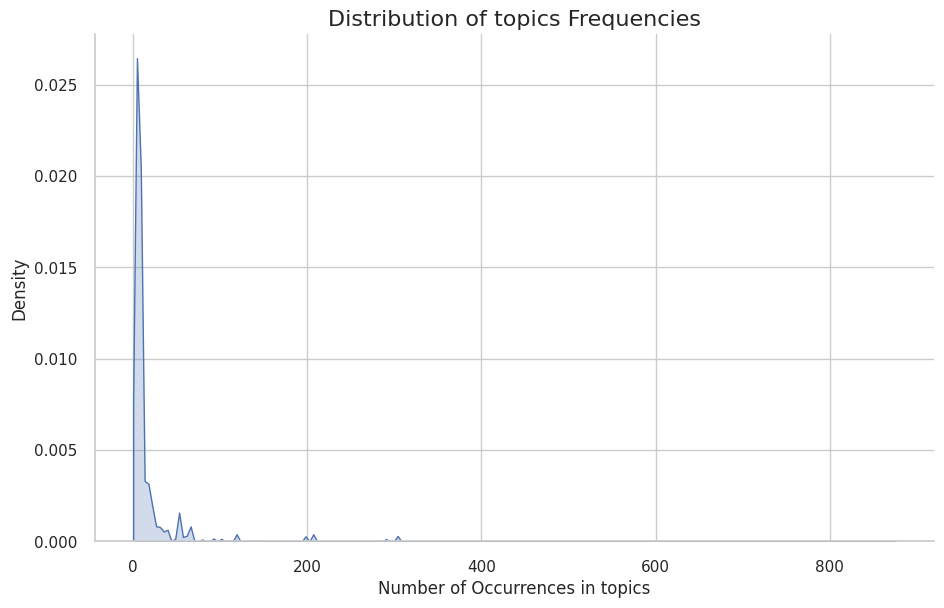

In [11]:
def show_dist_plot(df, variable, bw_adjust):
    # aesthetics
    sns.set(style="whitegrid", palette="deep")
    
    plt.figure(figsize=(10, 6))
    sns.displot(
        df[variable].value_counts(),
        kind="kde", # kernel density estimation
        bw_adjust=bw_adjust,
        fill=True, 
        height=6,  
        aspect=1.6  
    )
    
    plt.title(f'Distribution of {variable} Frequencies', fontsize=16)
    plt.xlabel(f'Number of Occurrences in {variable}', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    plt.show()
    
topics_df = df.explode('topics')
show_dist_plot(topics_df, 'topics', 0.05)


- The above density distribution shows that there is a peak at the initial number of occurences, which means that we have a lot of low-lying topics that are less frequently covered. This suggests that we have a big dispersion at topics level as a good number of the articles will have different topics.
- However we can still see that there are certain topics that are more prevalent than others even though they are of small numbers. This could mean that during our period, we had a massive focus over some specific kind of news and the number of topics that were most frequently covered was small.


In [12]:
topics_df["topics"].value_counts().describe()

count    3918.000000
mean        6.365493
std        27.038700
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max       875.000000
Name: count, dtype: float64

The numbers confirms our observation, we can clearly see that our biggest number of article around a specific topic is 875 but 75% of the news population is sitting at 4 articles at best.
- This suggest that we are more likely to uncover insights from the top population from topics point of view and less likely to find anything in the bottom population as it is quite dispersed.

### Top Population

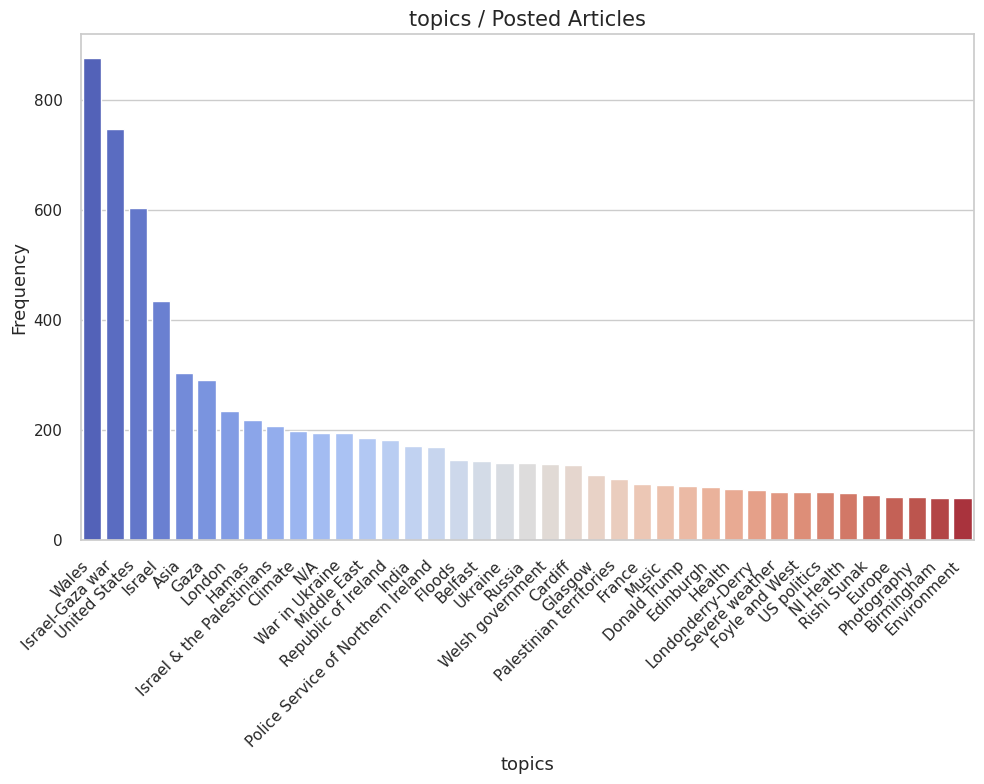

In [13]:
def threshold_and_plot(name, series, quantile, top=True):
    threshold = series.value_counts().quantile(quantile)
    if top:
        frequency = series.value_counts()[series.value_counts() > threshold]
    else:
        frequency = series.value_counts()[series.value_counts() < threshold]

    sns.set(style="whitegrid")

    fig, ax = plt.subplots(figsize=(10, 8))
    
    sns.barplot(
        x=frequency.index,
        y=frequency.values,
        hue=frequency.index,
        palette="coolwarm",
        ax=ax,
        legend=False
    )

    ax.set_title(f'{name} / Posted Articles', fontsize=15)
    ax.set_xlabel(name, fontsize=13)
    ax.set_ylabel('Frequency', fontsize=13)

    plt.xticks(rotation=45, ha='right', fontsize=11)

    plt.tight_layout()
    plt.show()

threshold_and_plot('topics', topics_df['topics'], 0.99)


Plotting the distribution of the top 1% population confirms our observation. Amongst the top 1%, we can notice a massive domination of news related to: Wales, Israel-Gaza war and the United States, whilst the other topics fall within the same range wihtout any noticeable dominance.
- Having so many categories on just 1% of the population also confirms our observation regarding the dispersion of our data.


Strangely enough, We are not aware of anything "Big" in Wales. Is there any topic of focus in there during this period? So much as outnumbering the Israel-Gaza War news?

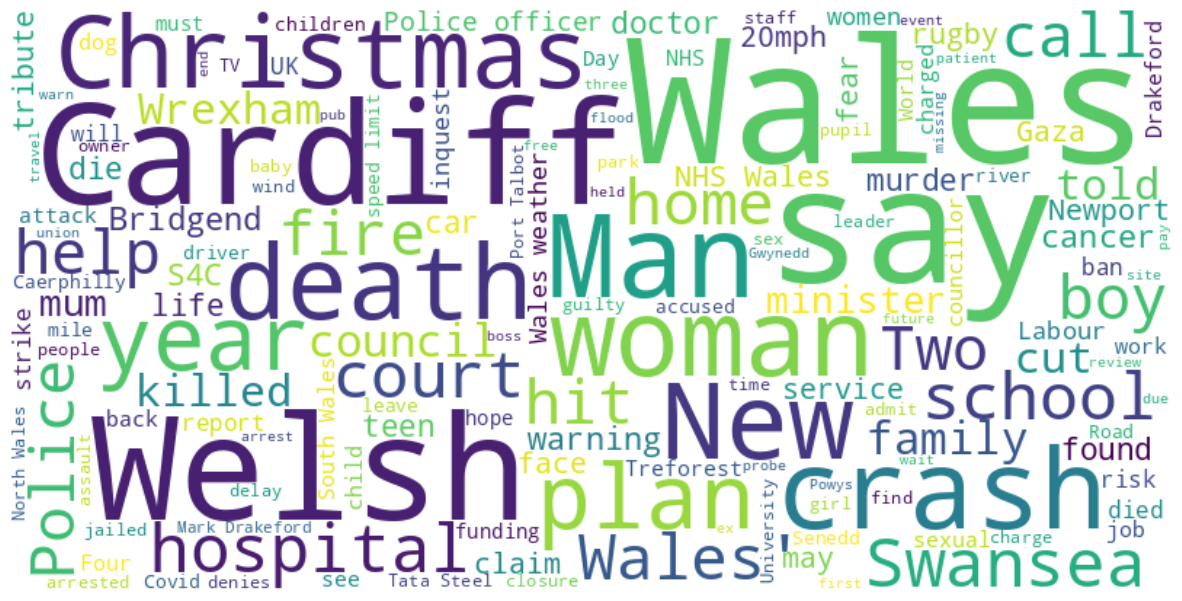

In [14]:
joined_wales_titles = " ".join(topics_df[topics_df['topics'] == 'Wales']['title'])

wordcloud = WordCloud(
    width=800,
    height=400,
    stopwords=STOPWORDS,
    background_color='white',
    max_words=150,
    max_font_size=120,
    random_state=42,
    colormap='viridis'
).generate(joined_wales_titles)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


The word cloud of the articles titles shows that the most used words revolve around Wales capital "Cardiff", christmas and new years.
We can also see some words such as "death", "crash", "hospital", "killed", "Police" etc. which suggest that there is a rise in the number of crimes and accidents in Wales during the new years period.
Strangely enough, we also see the word "Gaza" in wales topics. Maybe this is could be explained with the news about the calls for cease-fire?

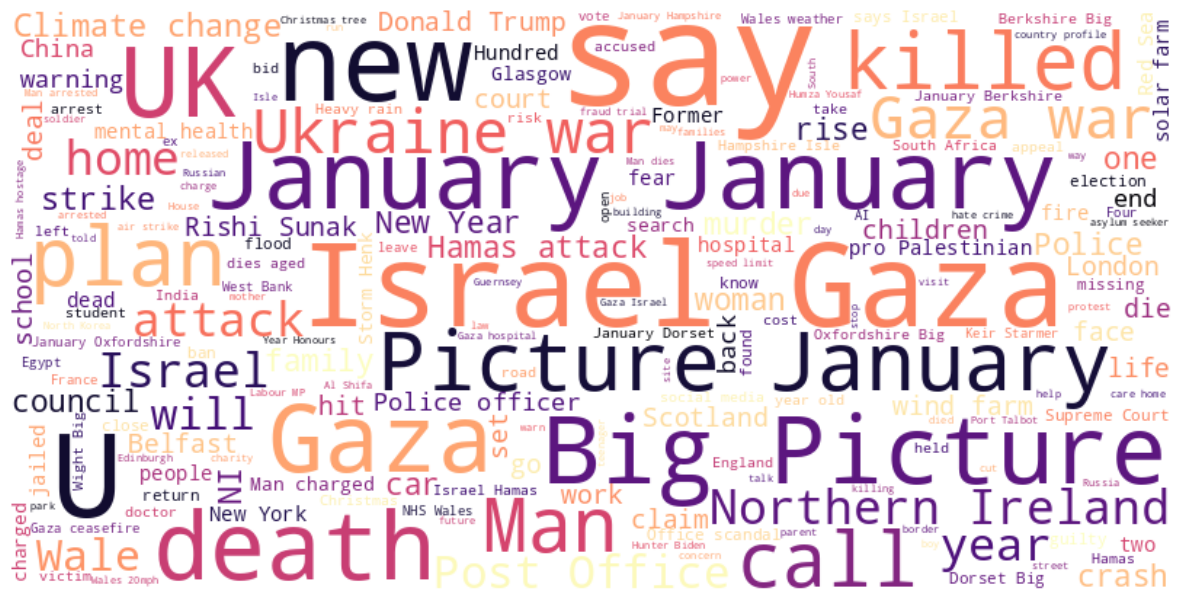

In [15]:
joined_titles = " ".join(topics_df['title'])

wordcloud = WordCloud(
    width=800,
    height=400,
    stopwords=STOPWORDS,
    background_color='white',
    max_words=200,
    max_font_size=100,
    random_state=42,
    colormap='magma' 
).generate(joined_titles)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


The word cloud of the articles titles shows that the most used words revolve around war.
We can see some such as "war", "killed", "arrest", "climate change", "murder", "attack", "missing", "fear" etc. all of which makes us think about war. We can also see the name of different countries in there "India", "France", "Northern Ireland", "China", "Ukraine", "UK" etc. Which leads us to also think in the given context about the calls for cease-fire, support for the victims, etc. 


### Bottom Population

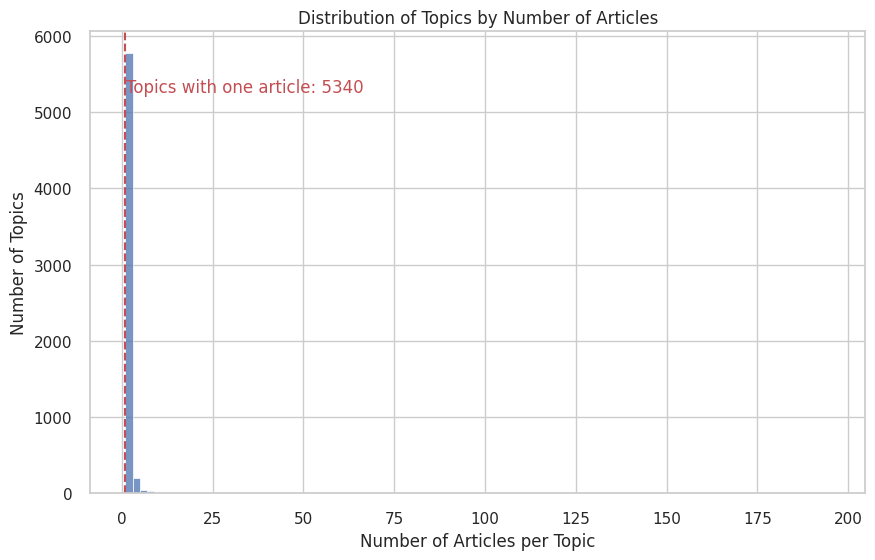

In [16]:
topic_frequency = df['topics'].value_counts()

plt.figure(figsize=(10, 6))
sns.histplot(topic_frequency, bins=100, kde=False)
plt.xlabel('Number of Articles per Topic')
plt.ylabel('Number of Topics')
plt.title('Distribution of Topics by Number of Articles')

one_article_count = (topic_frequency == 1).sum()
plt.axvline(x=1, color='r', linestyle='--')
plt.text(1.1, plt.ylim()[1]*0.9, f'Topics with one article: {one_article_count}', color='r', verticalalignment='top')

plt.show()

In [17]:
print(f"Out of {len(topic_frequency)} topic, one article topics count is of {one_article_count / len(topic_frequency) * 100} %")

Out of 6082 topic, one article topics count is of 87.80006576783953 %


To confirm our observations regarding the low-end of article topics, we plotted the number of articles with a single topic in the graph above. This represents a very big number of our articles.
Out of 6082 topics, 5340 topics are represented with a single article, consisting approximately 88% of the population. Our conclusion for this is either very infrequent topics once in a while or the overuse of the topics tags.

## Categories

<Figure size 1000x600 with 0 Axes>

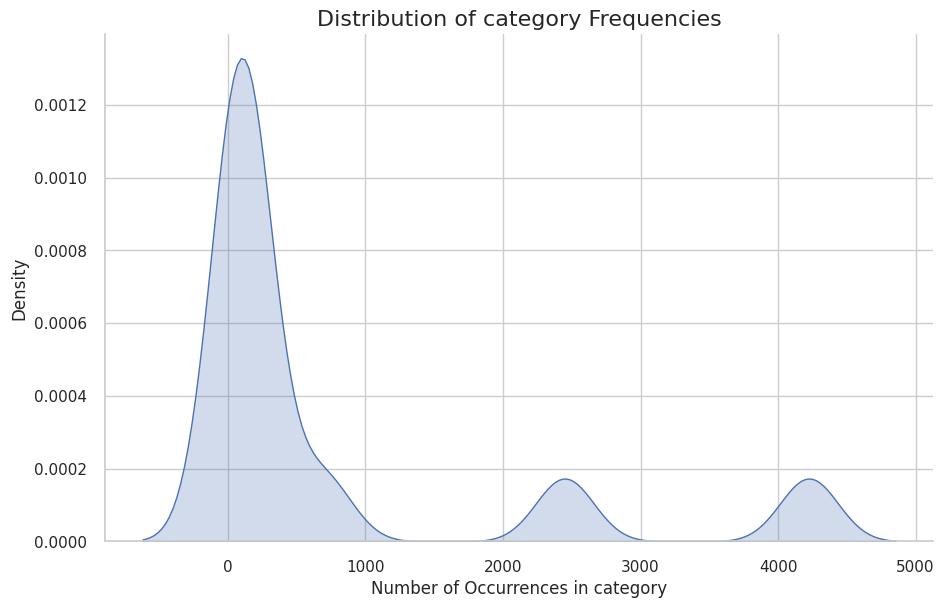

In [18]:
show_dist_plot(df, "category", 0.25)

- Whilst being a better than topics distribution, the above density distribution also shows that there is a peak at the initial number of occurences , which means that we have a lot of low-lying categories once again. This suggests that we have yet another dispersion at categories level as a good number of the articles will have different categories.

- We also can still see that there are certain categories  are more prevalent than others even though they are of small numbers. This could mean that during our period, we had a massive focus over some specific kind of categories and the number of categories that were most frequently covered was small.

We have had the same observation for the category as for the topics. Could these 2 variables correlate? If so, this could indicate that the tagging was consistently done for the articles across categories

### Correlation Analysis

In [19]:
contingency_table = pd.crosstab(topics_df['category'], topics_df['topics'])
contingency_table

topics                #MeToo campaign  100 Women  2022 Iran protests  5G  A&E  \
category                                                                        
Business                            0          0                   0   0    0   
Climate                             0          6                   0   0    0   
Entertainment & Arts                0          0                   0   0    0   
Health                              0          0                   0   0    1   
Israel-Gaza war                     0          0                   0   0    0   
Newsbeat                            0          0                   0   0    0   
Science                             0          0                   0   0    0   
Tech                                0          0                   0   0    0   
UK                                  0          0                   0   2    1   
War in Ukraine                      0          0                   0   0    0   
World                               5          5                  10   0    0   

topics                A14  ADHD  ATMs  Abdul Fattah al-Sisi  Abdullah II  ...  \
category                                                                  ...   
Business                0     0     0                     0            0  ...   
Climate                 0     0     0                     0            0  ...   
Entertainment & Arts    0     0     0                     0            0  ...   
Health                  0     0     0                     0            0  ...   
Israel-Gaza war         0     0     0                     1            1  ...   
Newsbeat                0     0     0                     0            0  ...   
Science                 1     0     0                     0            0  ...   
Tech                    0     0     0                     0            0  ...   
UK                      1     3     1                     0            0  ...   
War in Ukraine          0     0     0                     0            0  ...   
World                   0     0     0                     3            0  ...   

topics                Zaporizhzhia  Zaporizhzhia nuclear power plant  \
category                                                               
Business                         0                                 0   
Climate                          0                                 0   
Entertainment & Arts             0                                 0   
Health                           0                                 0   
Israel-Gaza war                  0                                 0   
Newsbeat                         0                                 0   
Science                          0                                 0   
Tech                             0                                 0   
UK                               0                                 0   
War in Ukraine                   2                                 1   
World                            0                                 0   

topics                Zimbabwe  Zoological Society of London  \
category                                                       
Business                     0                             0   
Climate                      0                             0   
Entertainment & Arts         0                             0   
Health                       0                             0   
Israel-Gaza war              0                             0   
Newsbeat                     0                             0   
Science                      0                             0   
Tech                         0                             0   
UK                           0                             1   
War in Ukraine               0                             0   
World                       11                             0   

topics                Zoos and Zoology  al-Shabab  c2c  eBay  eSports  iPhones  
category                                 

Our contingency table is very huge, and would lead to sensitive chi-square tests as data may have independent ways for observed frequencies. We will limit this section to our top 1% topics so that we eliminate the sparse data.

In [20]:
topic_counts = topics_df['topics'].value_counts()

one_percent_threshold = topic_counts.quantile(0.99)

top_topics = topic_counts[topic_counts >= one_percent_threshold].index

filtered_df = topics_df[topics_df['topics'].isin(top_topics)]

contingency_table = pd.crosstab(filtered_df['category'], filtered_df['topics'])
contingency_table

topics                Asia  Belfast  Birmingham  Cardiff  Climate  \
category                                                            
Business                 0        0           0        0        0   
Climate                  6        1           1        1      198   
Entertainment & Arts     0        0           1        0        0   
Health                   0        0           1        0        0   
Israel-Gaza war          3        8           9        3        0   
Newsbeat                 0        0           0        0        0   
Science                  0        0           0        0        0   
Tech                     0        0           0        0        0   
UK                       0      130          58      129        0   
War in Ukraine           2        0           0        0        0   
World                  293        5           7        3        0   

topics                Donald Trump  Edinburgh  Environment  Europe  Floods  \
category                                                                     
Business                         0          0            3       0       0   
Climate                          1          1           30       1      10   
Entertainment & Arts             0          0            0       0       0   
Health                           0          0            0       0       0   
Israel-Gaza war                  0          3            0       5       0   
Newsbeat                         0          0            0       0       0   
Science                          0          0            1       0       7   
Tech                             0          0            0       0       1   
UK                               0         89           30       2     119   
War in Ukraine                   0          0            0       3       0   
World                           97          3           13      68       9   

topics                ...  Republic of Ireland  Rishi Sunak  Russia  \
category              ...                                             
Business              ...                    0            0       0   
Climate               ...                    1            3       0   
Entertainment & Arts  ...                    0            0       0   
Health                ...                    0            0       0   
Israel-Gaza war       ...                   10           13       5   
Newsbeat              ...                    0            0       0   
Science               ...                    0            0       0   
Tech                  ...                    0            0       0   
UK                    ...                    9           35       0   
War in Ukraine        ...                    0            1      95   
World                 ...                  162           30      40   

topics                Severe weather  US politics  Ukraine  United States  \
category                                                                    
Business                           0            0        0              0   
Climate                           10            0        0              5   
Entertainment & Arts               0            0        0              0   
Health                             0            0        0              0   
Israel-Gaza war                    0            4        4             59   
Newsbeat                           0            0        0              0   
Science                           18            0        0              0   
Tech                               1            0        0              0   
UK                                39            0        0              0   
War in Ukraine                     1            3      123             14   
World                             18           80       13            526   

topics                Wales  War in Ukraine  Welsh government  
category                                                       
Business                  1      

In [21]:

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-squared: {chi2}")
print(f"P-value: {p}")

Chi-squared: 26120.00148799912
P-value: 0.0


The high Chi-squared value suggests a strong association between the two variables. We also have a p-value of 0 which means that the distribution of topics within categories is unlikely to be random and the results are statistically significant. 

In [22]:
def cramers_v(chi2, n, min_dim):
    return np.sqrt((chi2/n) / min_dim)

n = df.shape[0]
min_dim = min(contingency_table.shape) - 1
cramer_v = cramers_v(chi2, n, min_dim)
print(f"Cramer's V: {cramer_v}")


Cramer's V: 0.5648383861272944


We obtain a Cramer's V value of 0.56, this suggests a moderate to strong association between the topics and the category, we could conclude that the tagging was consistently done for the articles across categories.

In [23]:
df["category"].value_counts().describe()

count      11.000000
mean      744.272727
std      1354.654723
min         7.000000
25%        77.000000
50%       125.000000
75%       448.500000
max      4225.000000
Name: count, dtype: float64

The numbers confirms our initial observation, we can clearly see that our biggest number of article around a specific category is over 4k but 50% of the news population is sitting at 125 articles at best. This also confirms our distributions, whilst the distribution is better than topics one, it is still dispersed.

This also suggests once again that we are more likely to uncover insights from the top population from categories point of view and less likely to find anything in the bottom population as it is quite dispersed.

### Top Population

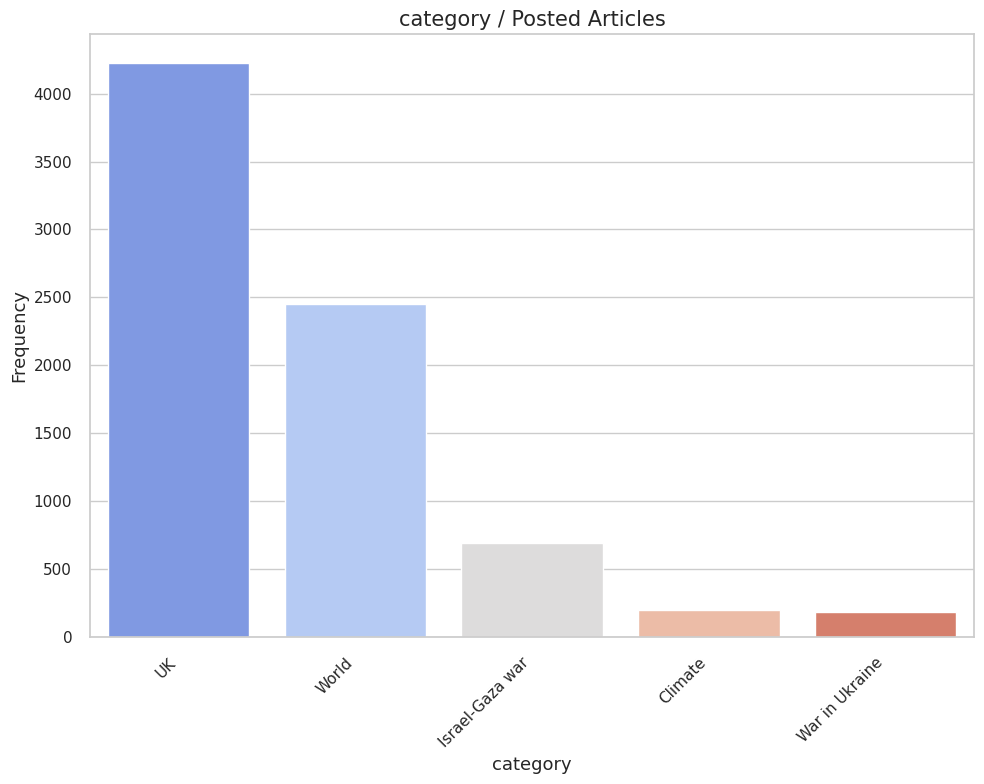

In [24]:
threshold_and_plot('category', df['category'], 0.5)

Amongst the top 50%, we can notice a massive domination of news related to: UK, World, Israel-Gaza war. This absolutely makes sense with our study so far. Wales belong to the UK which boosts its numbers alongside other countries. Although less frequent than Gaza-Israel, news around the world will have a higher cadence because it englobes more countries: US, India, Europe, etc. 

On the rear we can see Climate and War in Ukraine. While War in Ukraine could be getting less attention due to Israel-Gaza War, Climate topics also getting higher on the tendency due to the recent incidents. Climate is likely to be suffering due to the wars happening in both countries.

### Bottom Population

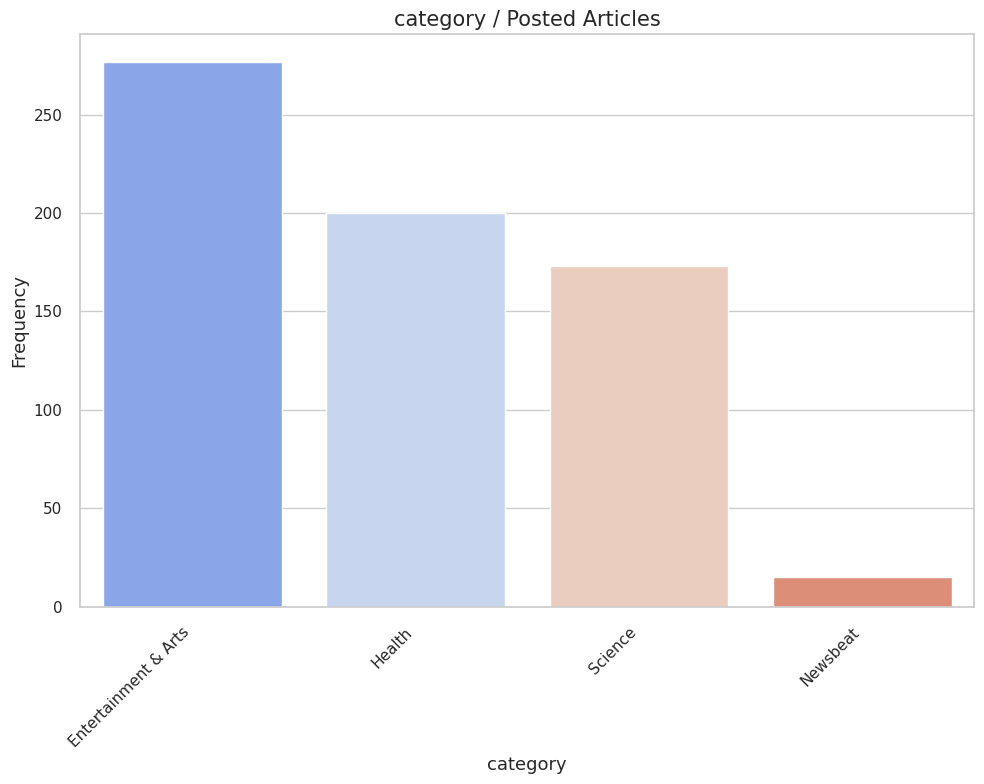

In [25]:
threshold_and_plot('category', topics_df['category'], 0.4, top=False)

On the lower end of categories, we find Entertainment & Arts, Health, Science. However if we notice the frequency, these are close to Ukraine-Russia article numbers. So maybe they are still getting attention but it is just the fact that other categories such as Israel-Gaza war are way more important. We also see diminishing number of articles around music "Newsbeat", more attention is given to wars and it only makes sense that we would not care much about singers & their concerts.

#### Subcategory Overview

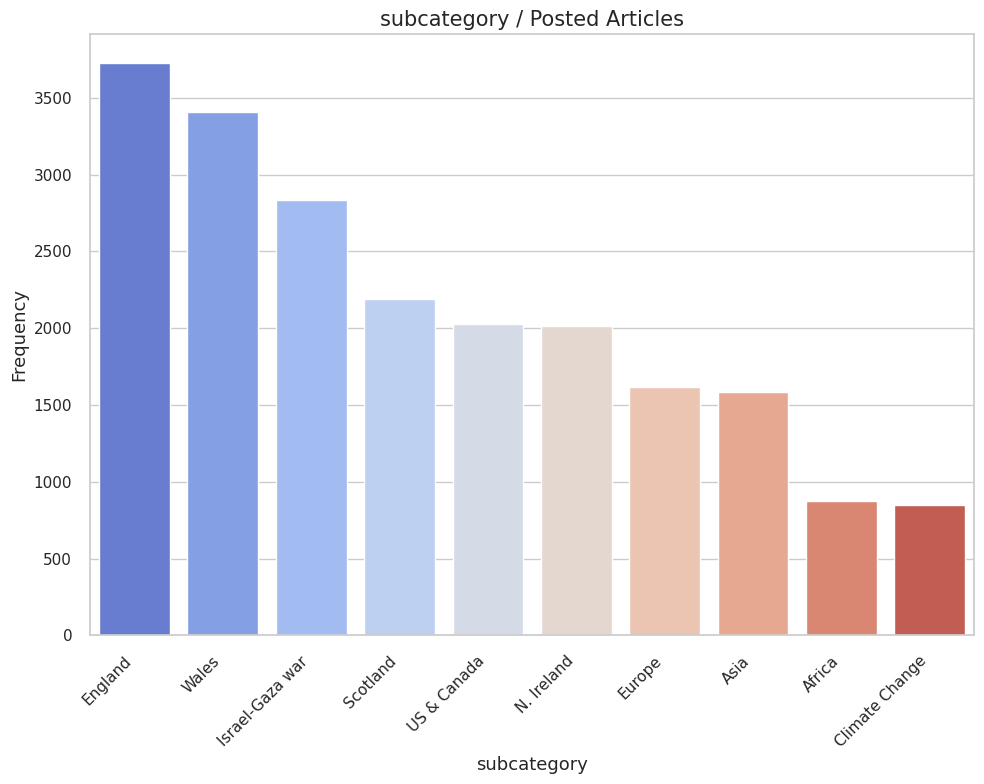

In [26]:
threshold_and_plot('subcategory', topics_df['subcategory'], 0.6)

This confirms our previous observation around the domination of UK and World over Israel-Gaza war as UK is carried by Wales, England, N. Ireland and Scotland.
Meanwhile World category is boosted by the fact that it has many countries as subcategories "US & Canada" and even whole continents "Europe, Asia and Africa".

## Authors

<Figure size 1000x600 with 0 Axes>

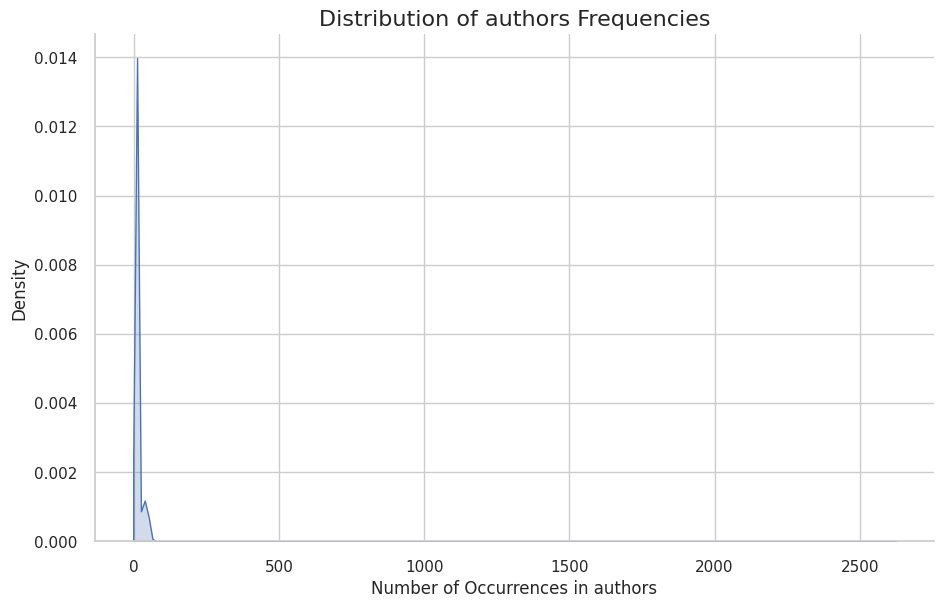

In [27]:
authors_df = df.explode('authors')

show_dist_plot(authors_df, 'authors', 0.05)

Once again, very biased data when it comes to the authors, there is a massive number of authors with only few published articles. Maybe due to the fact of them being new? or for the fact that we had alot of N/A variables during our scraping so they were not mentionned?

In [28]:
print(f'N/A authors percentage {authors_df[authors_df["authors"] == "N/A"].shape[0] / authors_df.shape[0] * 100}')

N/A authors percentage 27.89064993085842


A whole ~ 28%, so this could maybe confirm that theory.

In [29]:
authors_df["authors"].value_counts().describe()

count    1514.000000
mean        6.209379
std        67.649649
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max      2622.000000
Name: count, dtype: float64

As seen with the other 2 variables, this one is also very biased and 75% of the authors wrote at best 5 articles, while the max is sitting at an abnormal 2622 articles but this is probably the N/A.

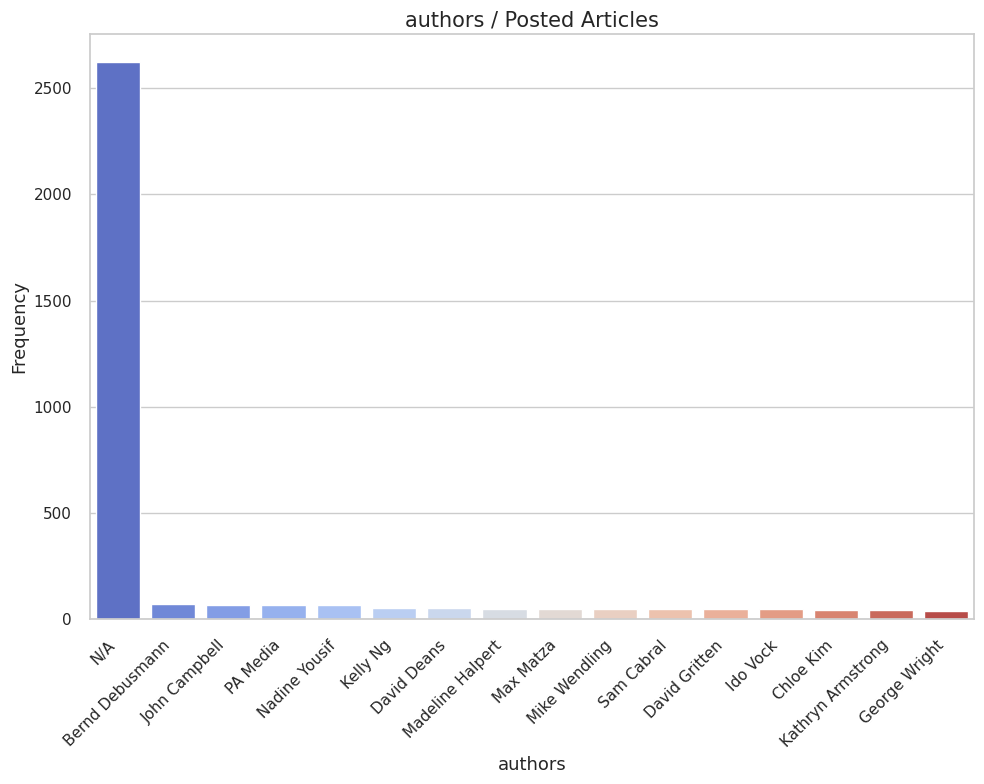

In [30]:
threshold_and_plot('authors', authors_df['authors'], 0.99)

This confirms our concerns, we shall recheck our numbers after masking N/A.

In [31]:
authors_df["authors"].explode('authors').replace('N/A', np.nan).dropna().value_counts().describe()

count    1513.000000
mean        4.480502
std         7.151223
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max        71.000000
Name: count, dtype: float64

Whilst giving better numbers, it is still the same distribution. 75% of the authors wrote at best 5 articles, while the max is sitting at 71 articles.

<Figure size 1000x600 with 0 Axes>

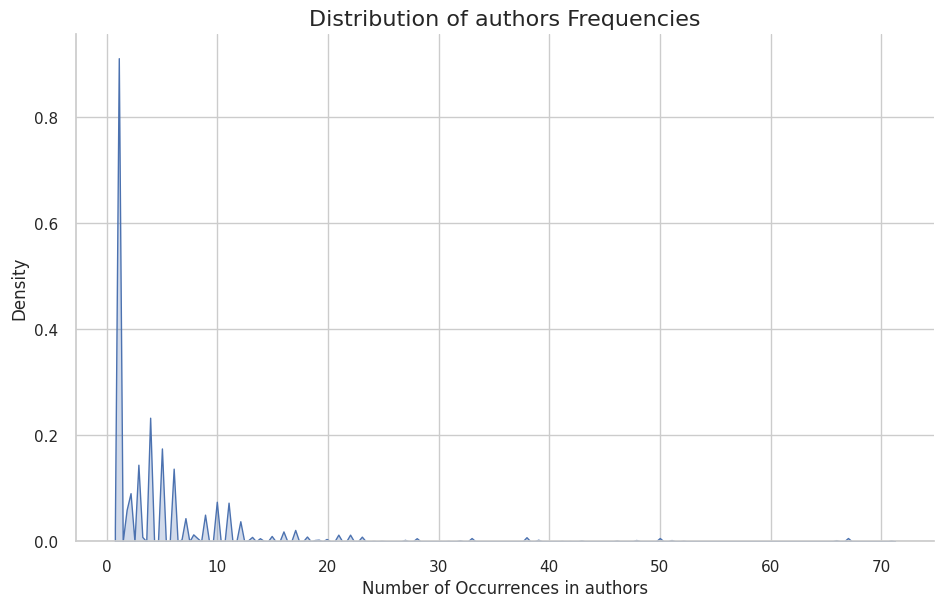

In [32]:
mask = (authors_df['authors'] == 'N/A') | (authors_df['authors'] == '')

masked_df = authors_df[~mask]

show_dist_plot(masked_df, 'authors', 0.05)

Confirming our numbers with the above plot, Even without N/A the data is still very biased and we have alot of authors with few articles.

## Top Population

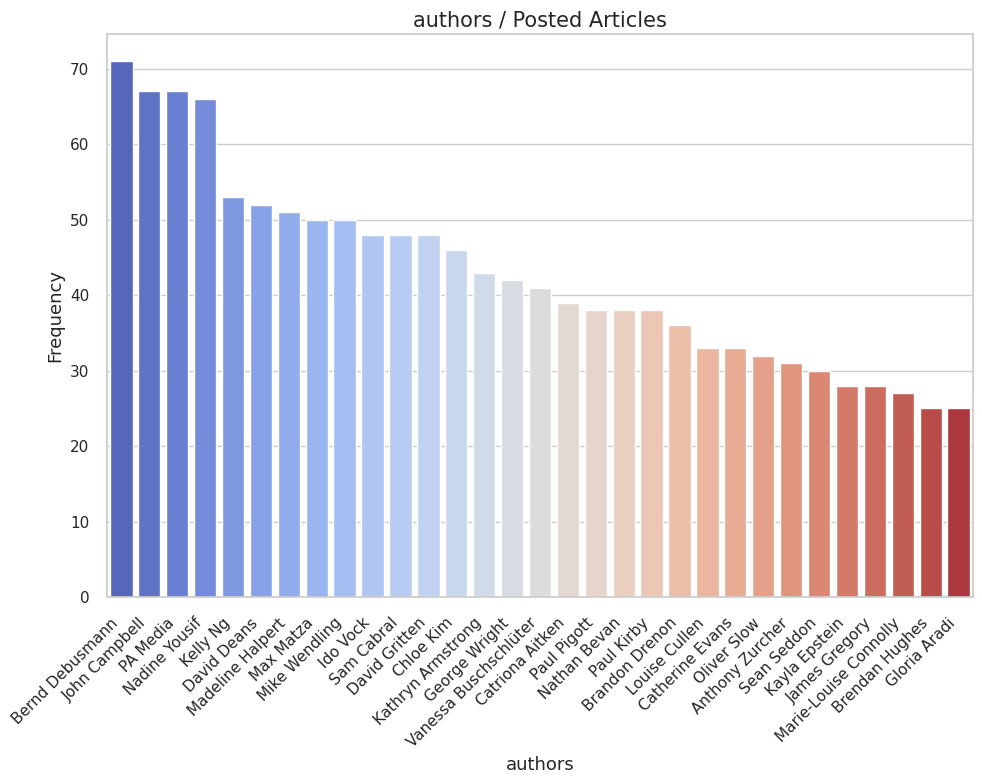

In [33]:
threshold_and_plot('authors', masked_df['authors'], 0.98)

Even though we have alot of inconsistent authors, we still have a great ammount of authors with a very good number of published articles with Bernd Debusmann taking the lead.

## Bottom Population

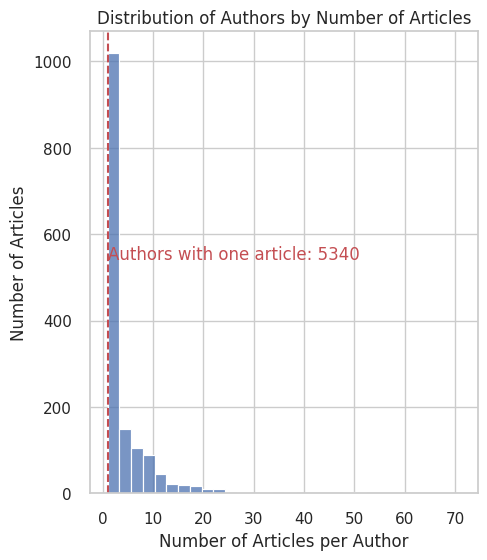

In [49]:
authors_frequency = masked_df['authors'].value_counts()

plt.figure(figsize=(5, 6))
sns.histplot(authors_frequency, bins=30, kde=False)
plt.xlabel('Number of Articles per Author')
plt.ylabel('Number of Articles')
plt.title('Distribution of Authors by Number of Articles')

one_article_count = (topic_frequency == 1).sum()
plt.axvline(x=1, color='r', linestyle='--')
plt.text(1.1, (one_article_count/10), f'Authors with one article: {one_article_count}', color='r', verticalalignment='bottom')
plt.show()


In [50]:
print(f"Out of {len(authors_frequency)} author, one article authors count is of {one_article_count / len(topic_frequency) * 100} %")

Out of 1512 author, one article authors count is of 87.80006576783953 %


This confirms our observations regarding the population from authors point of view being better than the previous variables.

# Sentiment Analysis:

In [51]:
def find_sentiment(article):
    try:
        if sia.polarity_scores(article)["compound"] > 0:
            return "Positive"
        elif sia.polarity_scores(article)["compound"] < 0:
            return "Negative"
        else:
            return "Neutral"  
    except:
        return "Neutral"

sia = SentimentIntensityAnalyzer()

df['sentiment'] = df['title'].apply(find_sentiment)
df.head()


uri  \
0  https://www.bbc.com/news/world-middle-east-679...   
1  https://www.bbc.com/news/world-middle-east-679...   
2         https://www.bbc.com/news/uk-wales-62134399   
3     https://www.bbc.com/news/world-africa-67911057   
4     https://www.bbc.com/news/world-africa-67914673   

                                               title  \
0  Al Jazeera bureau chief's son Hamza al-Dahdouh...   
1  Palestinians must be able to stay in Gaza - Bl...   
2  How does the new Wales-wide 20mph speed limit ...   
3  Ethiopia-Somaliland deal makes waves in Horn o...   
4  Betta Edu: Nigerian poverty minister suspended...   

                                            subtitle date_posted  \
0  The eldest son of Al Jazeera's Gaza bureau chi...  2024-01-08   
1  US Secretary of State Antony Blinken says Pale...  2024-01-08   
2  Motorists in Wales now have to limit their spe...  2024-01-08   
3  The defence minister of the self-declared repu...  2024-01-08   
4  Nigeria's president has suspended a minister o...  2024-01-08   

                                           full_text  \
0  The eldest son of Al Jazeera's Gaza bureau chi...   
1  US Secretary of State Antony Blinken says Pale...   
2  Motorists in Wales now have to limit their spe...   
3  The defence minister of the self-declared repu...   
4  Nigeria's president has suspended a minister o...   

                                              topics  \
0              [Israel-Gaza war, Journalism, Israel]   
1  [Israel & the Palestinians, Antony Blinken, He...   
2  [Climate, Welsh government, Environment, Motor...   
3                    [Somalia, Somaliland, Ethiopia]   
4                                          [Nigeria]   

                                              images  \
0  [https://ichef.bbci.co.uk/news/976/cpsprodpb/1...   
1  [https://ichef.bbci.co.uk/news/976/cpsprodpb/1...   
2  [https://ichef.bbci.co.uk/news/976/cpsprodpb/F...   
3  [https://ichef.bbci.co.uk/news/976/cpsprodpb/6...   
4  [https://ichef.bbci.co.uk/news/976/cpsprodpb/5...   

                                 authors         category      subcategory  \
0                       [Shaimaa Khalil]  Israel-Gaza war  Israel-Gaza war   
1                        [George Wright]  Israel-Gaza war  Israel-Gaza war   
2          [Nicola Bryan, Natalie Grice]          Climate   Climate Change   
3                          [Damian Zane]            World           Africa   
4  [Mansur Abubakar, Wedaeli Chibelushi]            World           Africa   

  sentiment  
0  Negative  
1   Neutral  
2   Neutral  
3   Neutral  
4  Negative

In [52]:
df["sentiment"].value_counts()

sentiment
Negative    3979
Neutral     2635
Positive    1573
Name: count, dtype: int64

our full_text based sentiment analysis suggests that we have quite a big number of negative and neutral articles which is normal given our context.

In [53]:
for idx, record in df[df["sentiment"] == "Positive"].head(3).iterrows():
    print(record.title, ": ", record.uri)

Hayao Miyazaki wins Golden Globe for The Boy and the Heron :  https://www.bbc.com/news/world-asia-67909246
Bangladesh election: PM Sheikh Hasina wins fourth term in controversial vote :  https://www.bbc.com/news/world-asia-67889387
China sanctions five US defence firms over Taiwan arms sales :  https://www.bbc.com/news/business-67909120


In [54]:
for idx, record in df[df["sentiment"] == "Negative"].head(3).iterrows():
    print(record.title, ": ", record.uri)

Al Jazeera bureau chief's son Hamza al-Dahdouh among journalists killed in Gaza :  https://www.bbc.com/news/world-middle-east-67905566
Betta Edu: Nigerian poverty minister suspended over money in personal bank account :  https://www.bbc.com/news/world-africa-67914673
TB Joshua: Megachurch leader raped and tortured worshippers, BBC finds :  https://www.bbc.com/news/world-africa-67749215


In [55]:
for idx, record in df[df["sentiment"] == "Neutral"].head(3).iterrows():
    print(record.title, ": ", record.uri)

Palestinians must be able to stay in Gaza - Blinken :  https://www.bbc.com/news/world-middle-east-67907336
How does the new Wales-wide 20mph speed limit law work? :  https://www.bbc.com/news/uk-wales-62134399
Ethiopia-Somaliland deal makes waves in Horn of Africa :  https://www.bbc.com/news/world-africa-67911057


We have a variety of articles between positive, negative and neutral. We can already spot that negative ones are related to war mostly, whilst positives are regarding other less frequent topics such as Golde Globe. The neutrals could be either positive or negative but we are unsure where they belong exactly as of now from a global point of view, we would have to dive in the articles for more details.

## Sentiments Distribution

In [56]:
author_expanded = df.explode('authors')
mask = (author_expanded['authors'] == '') | (author_expanded['authors'] == 'N/A')
author_expanded = author_expanded[~mask]
author_sentiment = author_expanded.groupby(['authors', 'sentiment']).size().unstack(fill_value=0)

author_sentiment.head()

sentiment              Negative  Neutral  Positive
authors                                           
Aaron Akinyemi                1        0         0
Abbie Jones                   0        0         2
Abdelali Ragad                1        0         0
Abdirahim Saeed               1        0         0
Abdujalil Abdurasulov         5        0         0

In [57]:
top_n = 5

top_positive_authors = author_sentiment.sort_values(by='Positive', ascending=False).head(top_n)

top_negative_authors = author_sentiment.sort_values(by='Negative', ascending=False).head(top_n)

melted_positive_authors = top_positive_authors.reset_index().melt(id_vars=['authors'], 
                                                                  var_name='Sentiment', 
                                                                  value_name='Count')
melted_negative_authors = top_negative_authors.reset_index().melt(id_vars=['authors'], 
                                                                  var_name='Sentiment', 
                                                                  value_name='Count')
melted_positive_authors.head()

authors Sentiment  Count
0     John Campbell  Negative     16
1          Kelly Ng  Negative     30
2  Madeline Halpert  Negative     31
3        Paul Kirby  Negative     18
4   Catherine Evans  Negative     20

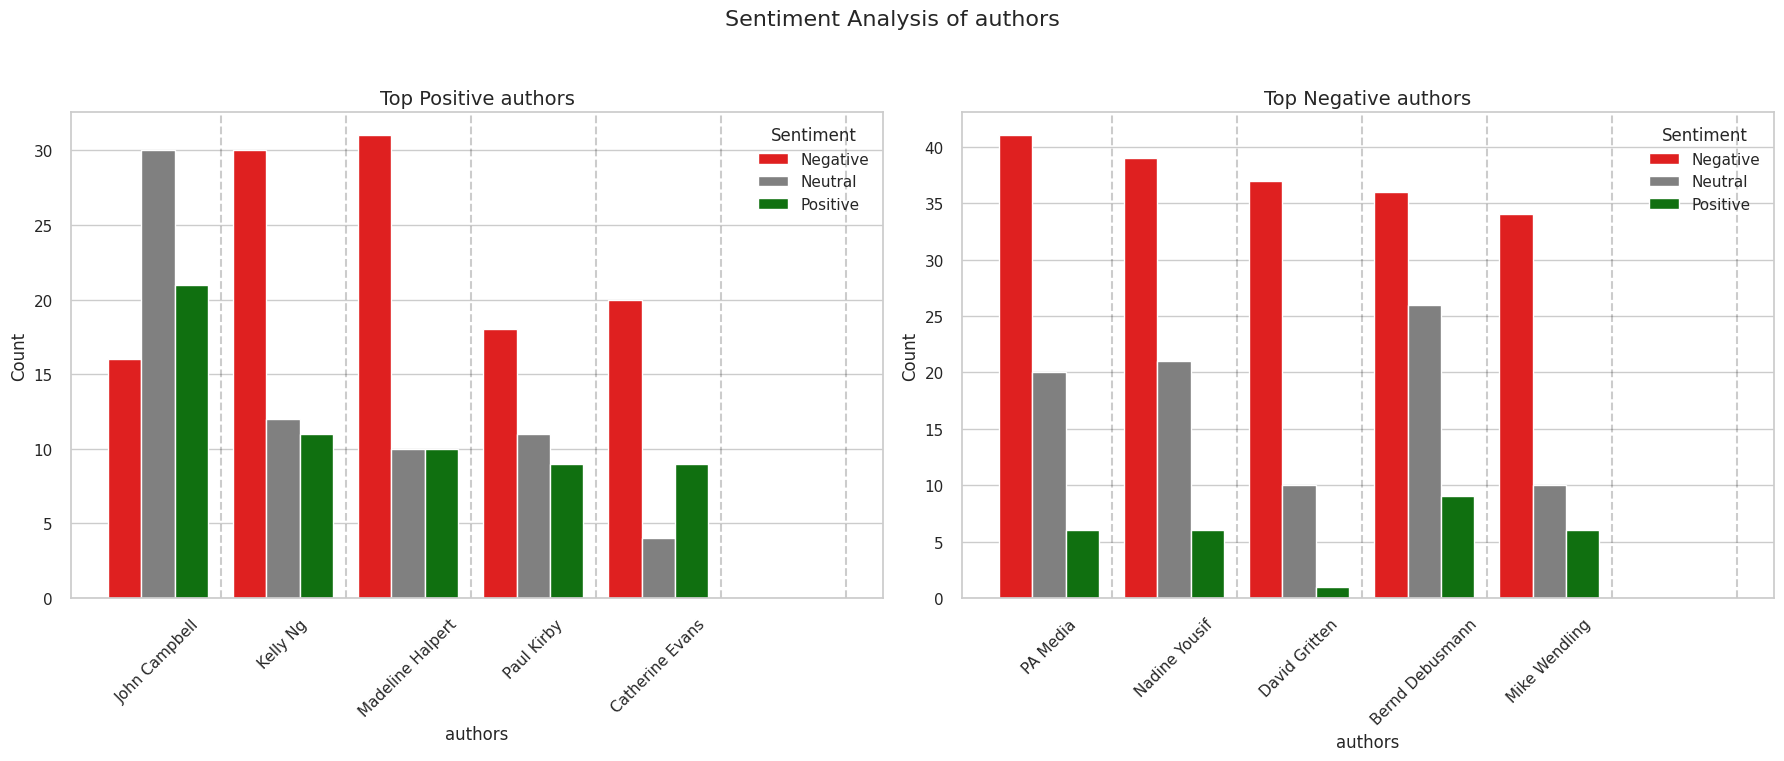

In [58]:
def plot_sentiment_analysis(melted_positive, melted_negative, category):
    sentiment_categories = ["Positive", "Negative", "Neutral"]
    
    plt.figure(figsize=(18, 8))

    sns.set(style="whitegrid")

    color_palette = {category: ("green" if category == "Positive" else "red" if category == "Negative" else "grey") 
                     for category in sentiment_categories}

    def add_group_background(ax):
        num_groups = len(ax.patches) // len(sentiment_categories)
        for i in range(0, num_groups):
            plt.axvline(x=i + 0.5, color='black', alpha=0.2, linestyle='--')

    plt.subplot(1, 2, 1)
    ax1 = sns.barplot(x=category, y='Count', hue='Sentiment', data=melted_positive, palette=color_palette)
    plt.title(f'Top Positive {category}', fontsize=14)
    plt.xlabel(category, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45)
    add_group_background(ax1)
    ax1.legend(loc='upper right', title='Sentiment')

    plt.subplot(1, 2, 2)
    ax2 = sns.barplot(x=category, y='Count', hue='Sentiment', data=melted_negative, palette=color_palette)
    plt.title(f'Top Negative {category}', fontsize=14)
    plt.xlabel(category, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45)
    add_group_background(ax2)
    ax2.legend(loc='upper right', title='Sentiment')

    plt.suptitle(f"Sentiment Analysis of {category}", fontsize=16)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.show()
    
plot_sentiment_analysis(melted_positive_authors, melted_negative_authors, 'authors')

The above plot reveals that John Campbel mostly writes about positive topics, however he has a greater deal of neutral topics, we cannot really conclude regarding his atittude. However for authors such as Kelly Ng and Madeline Halpert, even though they are supposed to be one of the authors with the biggest number of positive articles, they have a big deal of negative articles. It even outweights the positive with the neutrals stacked. Similarly for the top negative articles authors.

This leads us to think that most of the news that are posted frequently in BBC news by consistent authors are rather negative.

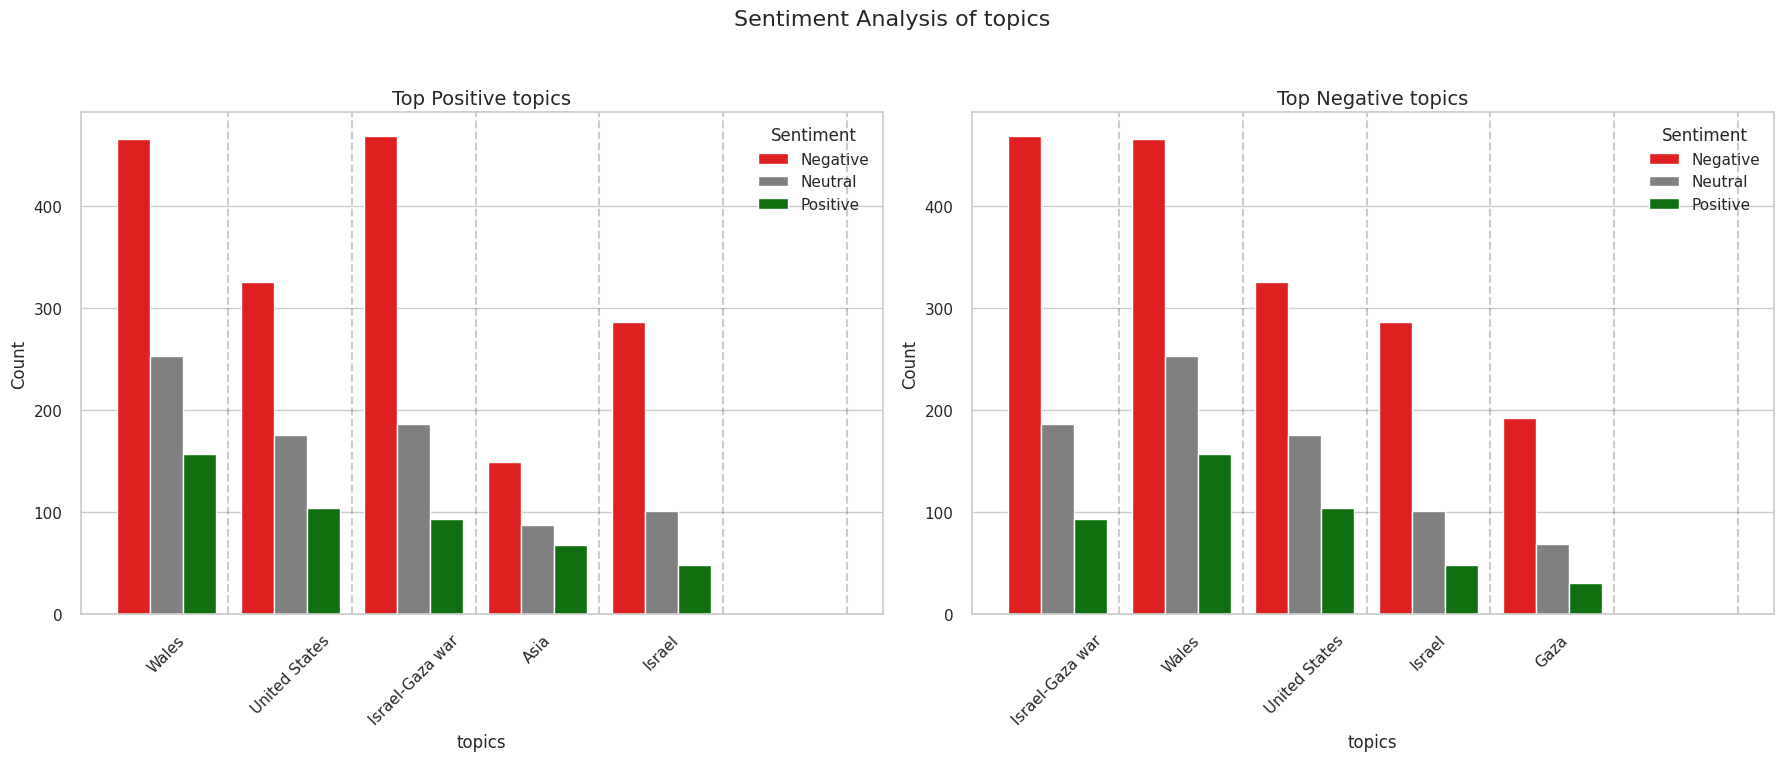

In [59]:
topics_expanded = df.explode('topics')
topic_sentiment = topics_expanded.groupby(['topics', 'sentiment']).size().unstack(fill_value=0)


top_positive_topics = topic_sentiment.sort_values(by='Positive', ascending=False).head(top_n)

top_negative_topics = topic_sentiment.sort_values(by='Negative', ascending=False).head(top_n)

melted_positive_topics = top_positive_topics.reset_index().melt(id_vars=['topics'], 
                                                                  var_name='Sentiment', 
                                                                  value_name='Count')
melted_negative_topics = top_negative_topics.reset_index().melt(id_vars=['topics'], 
                                                                  var_name='Sentiment', 
                                                                  value_name='Count')



plot_sentiment_analysis(melted_positive_topics, melted_negative_topics, 'topics')

Similarly, most of the articles by topic are mostly negative. With Wales taking the lead in positive articles but having a greater deal of negative ones. Meanwhile Israel-Gaza war obviously takes the lead in the negative ones. Interesting enough, Israel-Gaza war also comes third in the positive articles. 

This makes us conclude that the situation is really dire that we do not have many good news to post in the current period.

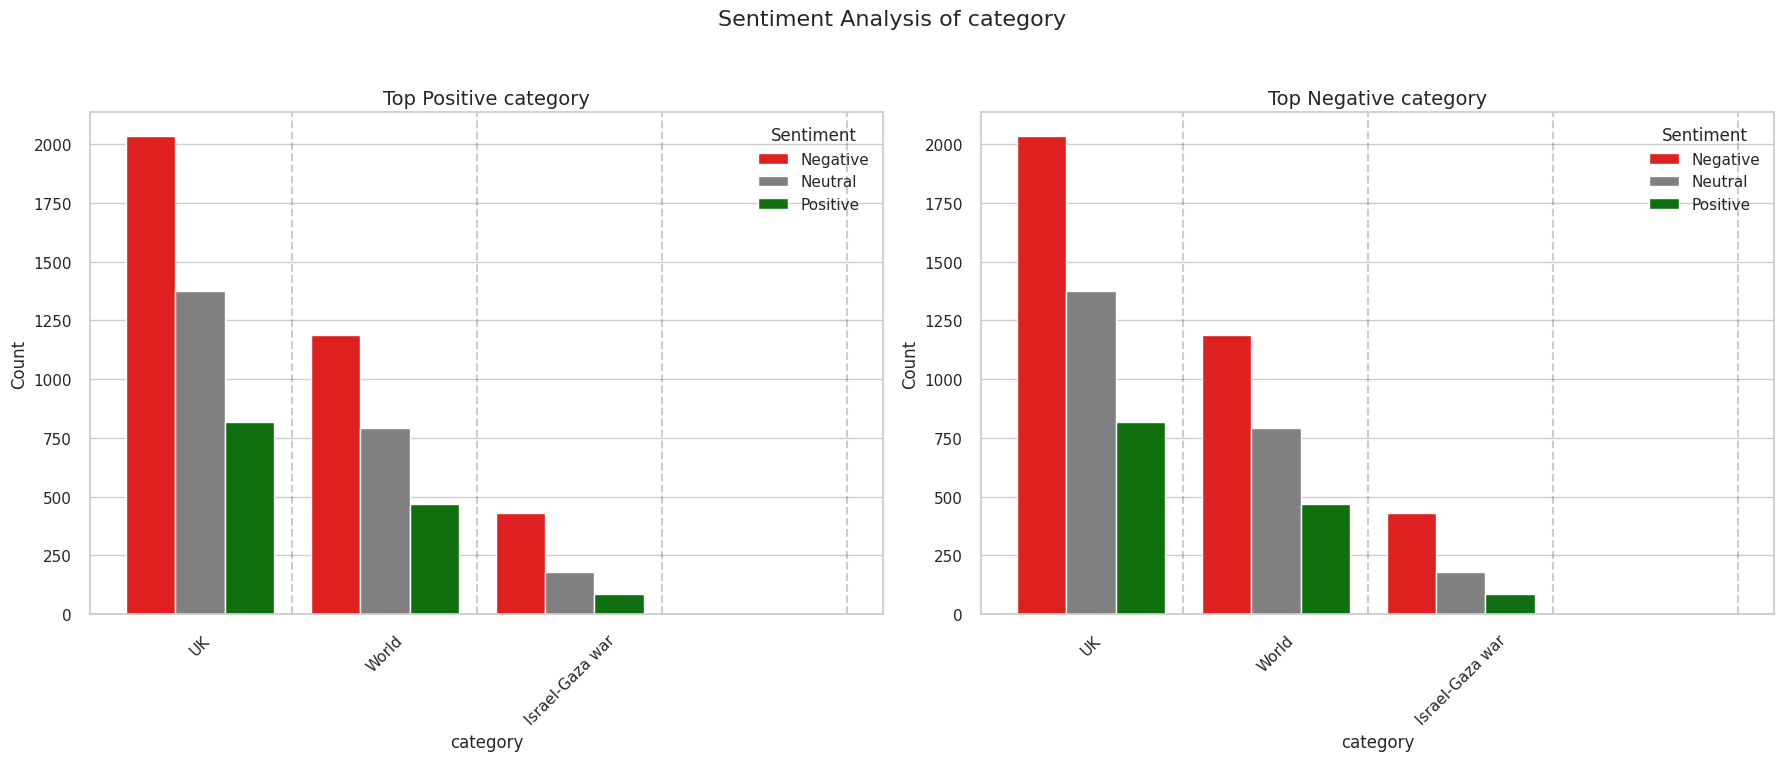

In [60]:
top_n = 3

category_sentiment = df.groupby(['category', 'sentiment']).size().unstack(fill_value=0)

top_positive_categories = category_sentiment.sort_values(by='Positive', ascending=False).head(top_n)

top_negative_categories = category_sentiment.sort_values(by='Negative', ascending=False).head(top_n)

melted_positive_categories = top_positive_categories.reset_index().melt(id_vars=['category'], 
                                                                  var_name='Sentiment', 
                                                                  value_name='Count')
melted_negative_categories = top_negative_categories.reset_index().melt(id_vars=['category'], 
                                                                  var_name='Sentiment', 
                                                                  value_name='Count')


plot_sentiment_analysis(melted_positive_categories, melted_negative_categories, 'category')

Finally we wanted to check where these negative sentiments are mostly stacked. The graph above confirms our theory regarding the dire situation we live in.
UK is the first in both psoitives and negatives despite the gigantic amount of negative articles they possess.

Maybe we are wrong due to the neutral articles, but as it looks now, the situation AIN'T GOOD AT ALL!

# Trend Analysis:

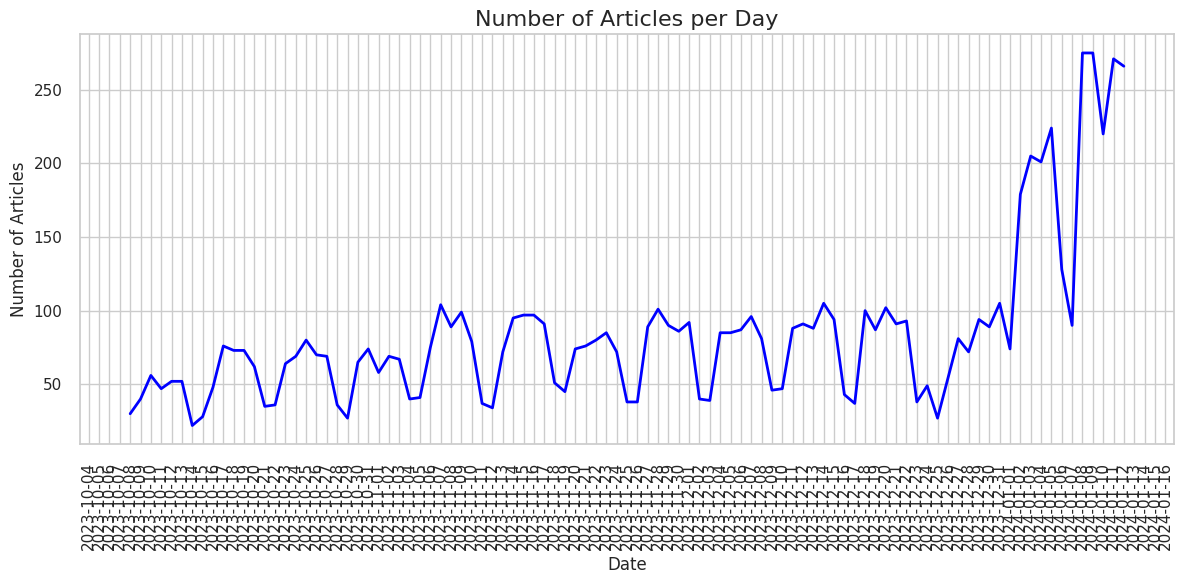

In [61]:
sns.set(style="whitegrid")

daily_articles = df.groupby(df['date_posted'].dt.date).size()

plt.figure(figsize=(12, 6))
plt.plot(daily_articles.index, daily_articles.values, color='blue', linewidth=2)

plt.title('Number of Articles per Day', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.xticks(rotation=90)

plt.grid(True)

plt.tight_layout()
plt.show()


Interestingly enough, we can see a pattern of ups and downs around the same number of articles per day during the last 3 months. With a peak on new years before going down once again and yet again another rather strange peak on the 9th.

In [62]:
df[df["date_posted"]=="2024-01-09"]["category"].value_counts()

category
UK                      191
World                    44
Health                   12
Entertainment & Arts      8
Science                   7
Tech                      4
Business                  3
Israel-Gaza war           2
War in Ukraine            2
Climate                   2
Name: count, dtype: int64

The numbers are concentrated more around England/UK on the 9th. This is due to the Post Office Scandal topic being one of the biggest misscariage of justice.

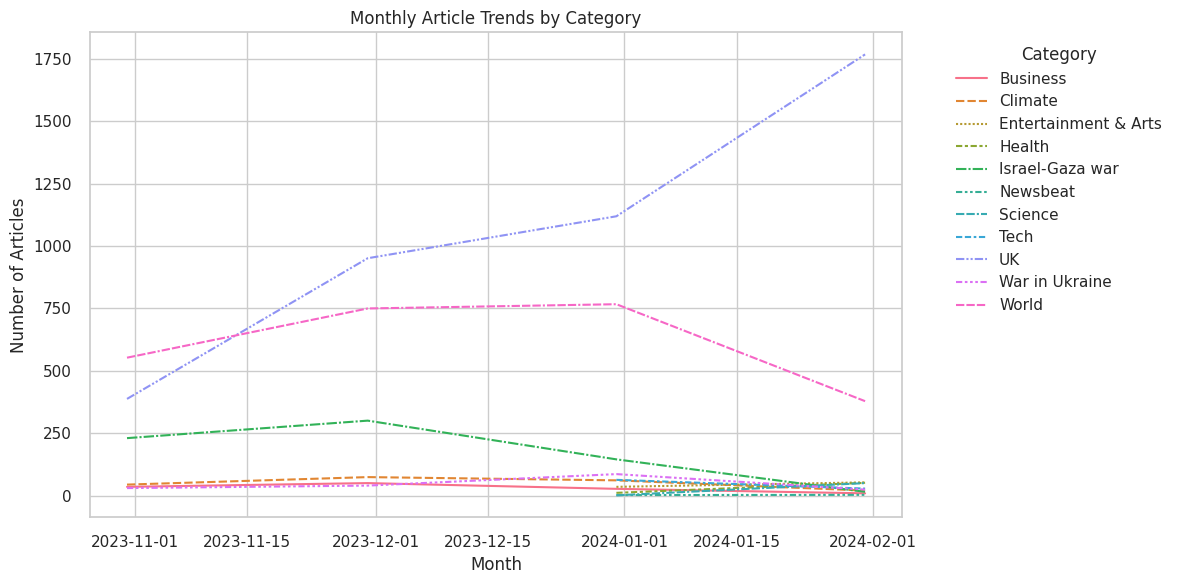

In [63]:
if df.index.name != 'date_posted':
    df.set_index('date_posted', inplace=True)
    
monthly_category_trends = df.groupby('category').resample('M').size().unstack(0)

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_category_trends)
plt.title('Monthly Article Trends by Category')
plt.xlabel('Month')
plt.ylabel('Number of Articles')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


As the previous analysis, this one only confirms it with the news around UK getting more and more trendy while the other categories are dying from the surface right now.
Interesting enough, despite how the situation in Israel-Gaza is way worse than the post office matter, the media is focused on internal UK matters more.

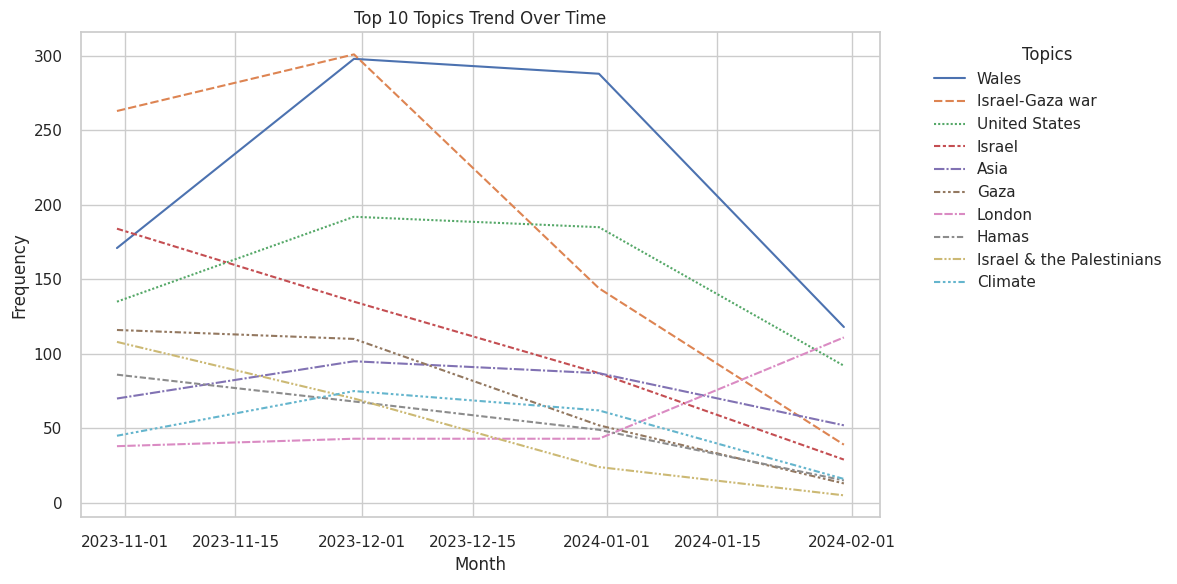

In [64]:
df_exploded = df.explode('topics')

monthly_topic_count = df_exploded.groupby('topics').resample('M').size().unstack(0)

top_topics = monthly_topic_count.sum(axis=0).sort_values(ascending=False).head(10).index
top_topics_data = monthly_topic_count[top_topics]

plt.figure(figsize=(12, 6))
sns.lineplot(data=top_topics_data)
plt.title('Top 10 Topics Trend Over Time')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Topics are also confirming the same analysis we conducted thus far. With wales being the trend on new years and London being the new trend nowadays in news. It is also interesting that we can see a pattern, whenever a topic gets trendy, the previous topics starts declining.

In [65]:
monthly_sentiment_trends = df.groupby('sentiment').resample('M').size().unstack(0)

monthly_sentiment_trends

sentiment    Negative  Neutral  Positive
date_posted                             
2023-10-31        678      387       219
2023-11-30       1105      670       394
2023-12-31       1088      753       485
2024-01-31       1108      825       475

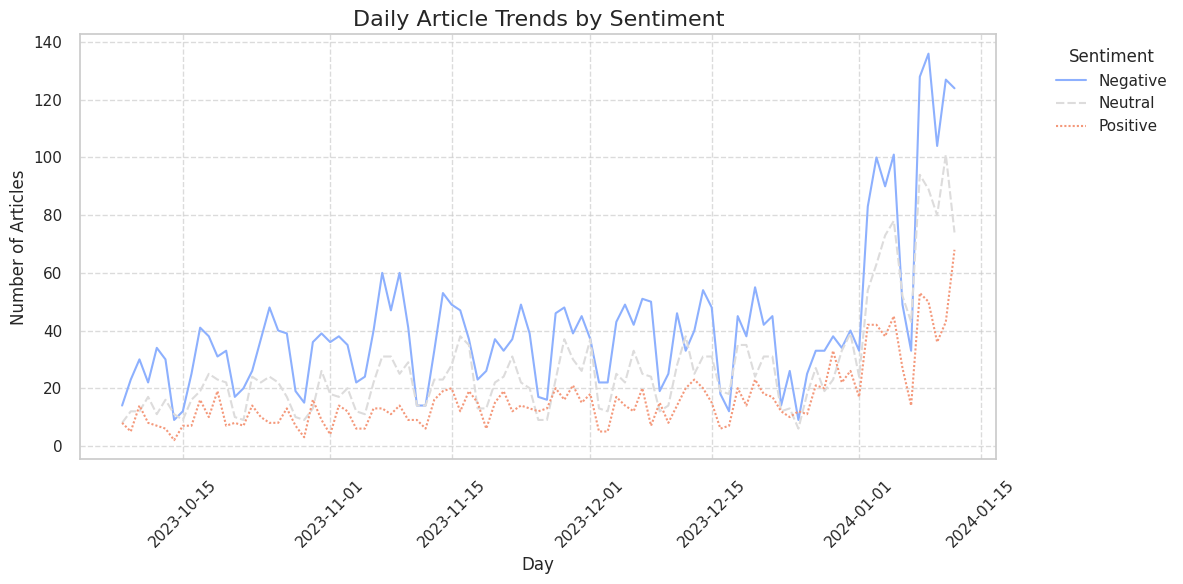

In [66]:
if df.index.name != 'date_posted':
    df.set_index('date_posted', inplace=True)

daily_sentiment_trends = df.groupby('sentiment').resample('D').size().unstack(0)

sentiment_colors = sns.color_palette("coolwarm", len(daily_sentiment_trends.columns))

plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_sentiment_trends, palette=sentiment_colors)

plt.title('Daily Article Trends by Sentiment', fontsize=16)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)  

plt.tight_layout()

plt.show()


Sentiments are going nowhere with the negatives being all time dominant at the same cadence with a peak at new years and post-office matters.

# Categorization:

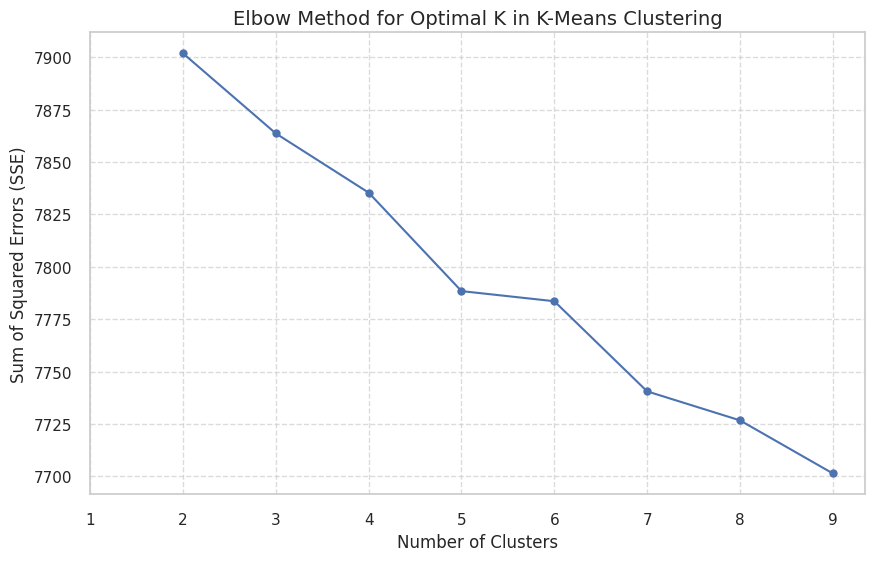

In [75]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['full_text'])

sse = {}

for num_clusters in range(2,10):
    km = KMeans(n_clusters=num_clusters, n_init=10)
    km.fit(tfidf_matrix)
    sse[num_clusters] = km.inertia_ 

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
plt.plot(list(sse.keys()), list(sse.values()), marker='o', color='b')

plt.xlabel("Number of Clusters", fontsize=12)
plt.ylabel("Sum of Squared Errors (SSE)", fontsize=12)
plt.title("Elbow Method for Optimal K in K-Means Clustering", fontsize=14)
plt.xticks(range(1, 10))
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()


With the above full-text similarity clustering, we can see that 6 clusters could be a good elbow point, but 8 clusters is also a good elbow point, lets check silhouettes for decision.

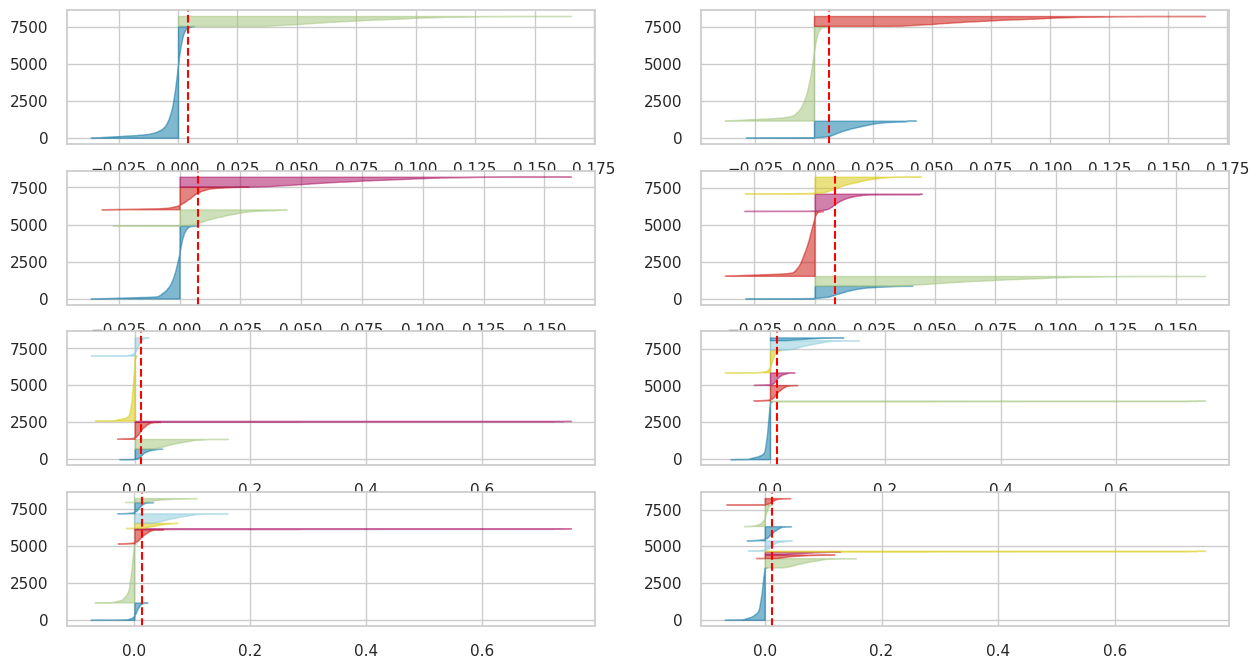

In [81]:
fig, ax = plt.subplots(4, 2, figsize=(15,8))
for num_clusters in range(2, 10):
    km = KMeans(n_clusters=num_clusters, n_init=10)
    
    q, mod = divmod(num_clusters, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    
    labels = visualizer.fit(tfidf_matrix) 


While the silhouettes aren't giving great figures, we can see that there is always one anomaly silhouette cluster. We also have all the time wide silhouettes. This is totally normal with the nautre of our data and will thus pick 6 clusters over 8 due to the homegenity of the other clusters.

The categorization will be done just for curiosity purposes and is not pertinent due to the silhouettes above. We could inspect more with bigger number of clusters but this would lead to keeping the data sparse which is not our goal.

In [84]:
km = KMeans(n_clusters=6, n_init=10)
km.fit(tfidf_matrix)
df['cluster'] = km.labels_

print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names_out()
for i in range(6):
    print(f"Cluster {i}:")
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]
    print(", ".join(top_terms))



Top terms per cluster:
Cluster 0:
police, man, said, officers, arrested, old, road, incident, crash, woman
Cluster 1:
said, people, mr, year, bbc, ms, years, says, told, court
Cluster 2:
said, council, external, bbc, government, uk, new, people, ireland, services
Cluster 3:
mr, trump, said, ukraine, party, government, president, election, russia, minister
Cluster 4:
pictures, picture, bbc, images, southweather, publish, watchers, upload, england, big
Cluster 5:
israel, gaza, hamas, israeli, said, palestinian, killed, people, hostages, war


**Cluster 0**
Crime and Law Enforcement:
- This cluster includes keywords related to police activities, arrests, and incidents, indicating a focus on law enforcement and criminal incidents.
    

**Cluster 1** 
General News and People Stories:
- The presence of a broad range of terms including 'year', 'people', 'court', and individual indicators like 'mr', 'ms' suggests this cluster covers a variety of general news stories, possibly including personal interest stories.

**Cluster 2**
 Government and Public Services:
-  Keywords such as 'council', 'government', 'services', and 'external' point to news related to local and national government activities, public services, and administrative matters.

**Cluster 3**
Political Leadership and Elections:
- This cluster is characterized by terms related to political figures, government, and elections, with a focus on topics like 'Trump', 'Ukraine', 'election', and 'president'. This seems more of an extension of the previous cluster

**Cluster 4**
Visual Content and Weather:
- This cluster seems to focus on visual content such as pictures and images, possibly related to weather events or viewer-submitted photographs.

**Cluster 5**
Middle East Affairs:
- The terms 'Israel', 'Gaza', 'Hamas', and 'Palestinian' indicate a focus on news and events related to the Middle East, particularly involving Israel and the Palestinian territories.

In [86]:
cluster_names = {
    0: 'Crime and Law Enforcement',
    1: 'General News and People Stories',
    2: 'Government and Public Services',
    3: 'Political Leadership and Elections',
    4: 'Visual Content and Weather',
    5: 'Middle East Affairs'
}

df['cluster'] = df['cluster'].replace(cluster_names)

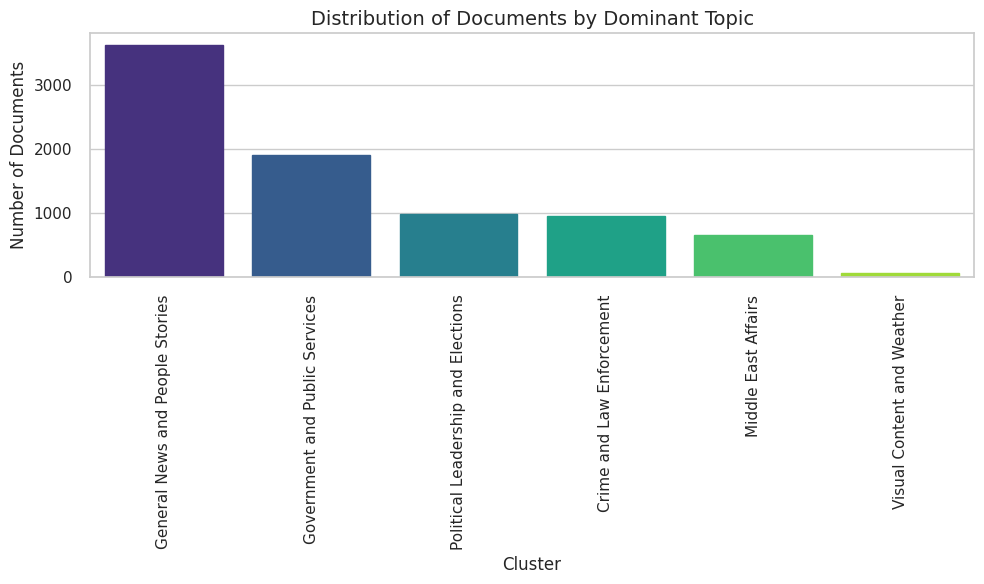

In [89]:
sns.set_style("whitegrid")

topic_counts = df['cluster'].value_counts()

plt.figure(figsize=(10, 6)) 
barplot = sns.barplot(x=topic_counts.index, y=topic_counts.values, color="blue") 

palette = sns.color_palette("viridis", n_colors=len(topic_counts))
for i, bar in enumerate(barplot.patches):
    bar.set_color(palette[i])

plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Number of Documents', fontsize=12)
plt.title('Distribution of Documents by Dominant Topic', fontsize=14)


plt.xticks(rotation=90) 
plt.tight_layout() 
plt.show()


In [90]:
df[df['cluster'] == "General News and People Stories"].explode('topics').topics.value_counts()

topics
Wales                   429
United States           295
Asia                    234
India                   154
Israel-Gaza war         130
                       ... 
Lottery                   1
Toronto                   1
Healthcare in the US      1
New Hampshire             1
Mackworth                 1
Name: count, Length: 2642, dtype: int64

We already said that Wales news covers a broad number of articles ranging from new years, traffic accidents etc. and in our clustering most of them were categorized as General News which makes sense. However our clustering could be not solid enough so we can already see a great deal about Israel-Gaza war in this cluster?

In [95]:
df_tmp = df[df['cluster'] == "General News and People Stories"].explode('topics')
for idx, record in df_tmp[df_tmp['topics'] == 'Israel-Gaza war'].head().iterrows():
    print(record.title, ": ", record.uri)

Awni Eldous: The Palestinian boy who found YouTube fame after death :  https://www.bbc.com/news/world-middle-east-67788360
What do Red Sea assaults mean for global trade? :  https://www.bbc.com/news/business-67759593
Hapag-Lloyd says Red Sea route still 'too dangerous' :  https://www.bbc.com/news/business-67827444
India deploys three warships to Arabian Sea after attack on tanker :  https://www.bbc.com/news/world-asia-india-67822247
'Bethlehem is empty of joy - no Santa, no celebration' :  https://www.bbc.com/news/world-middle-east-67815370


From an overview, these topics could be considered as general news.

# Authors collaboration network

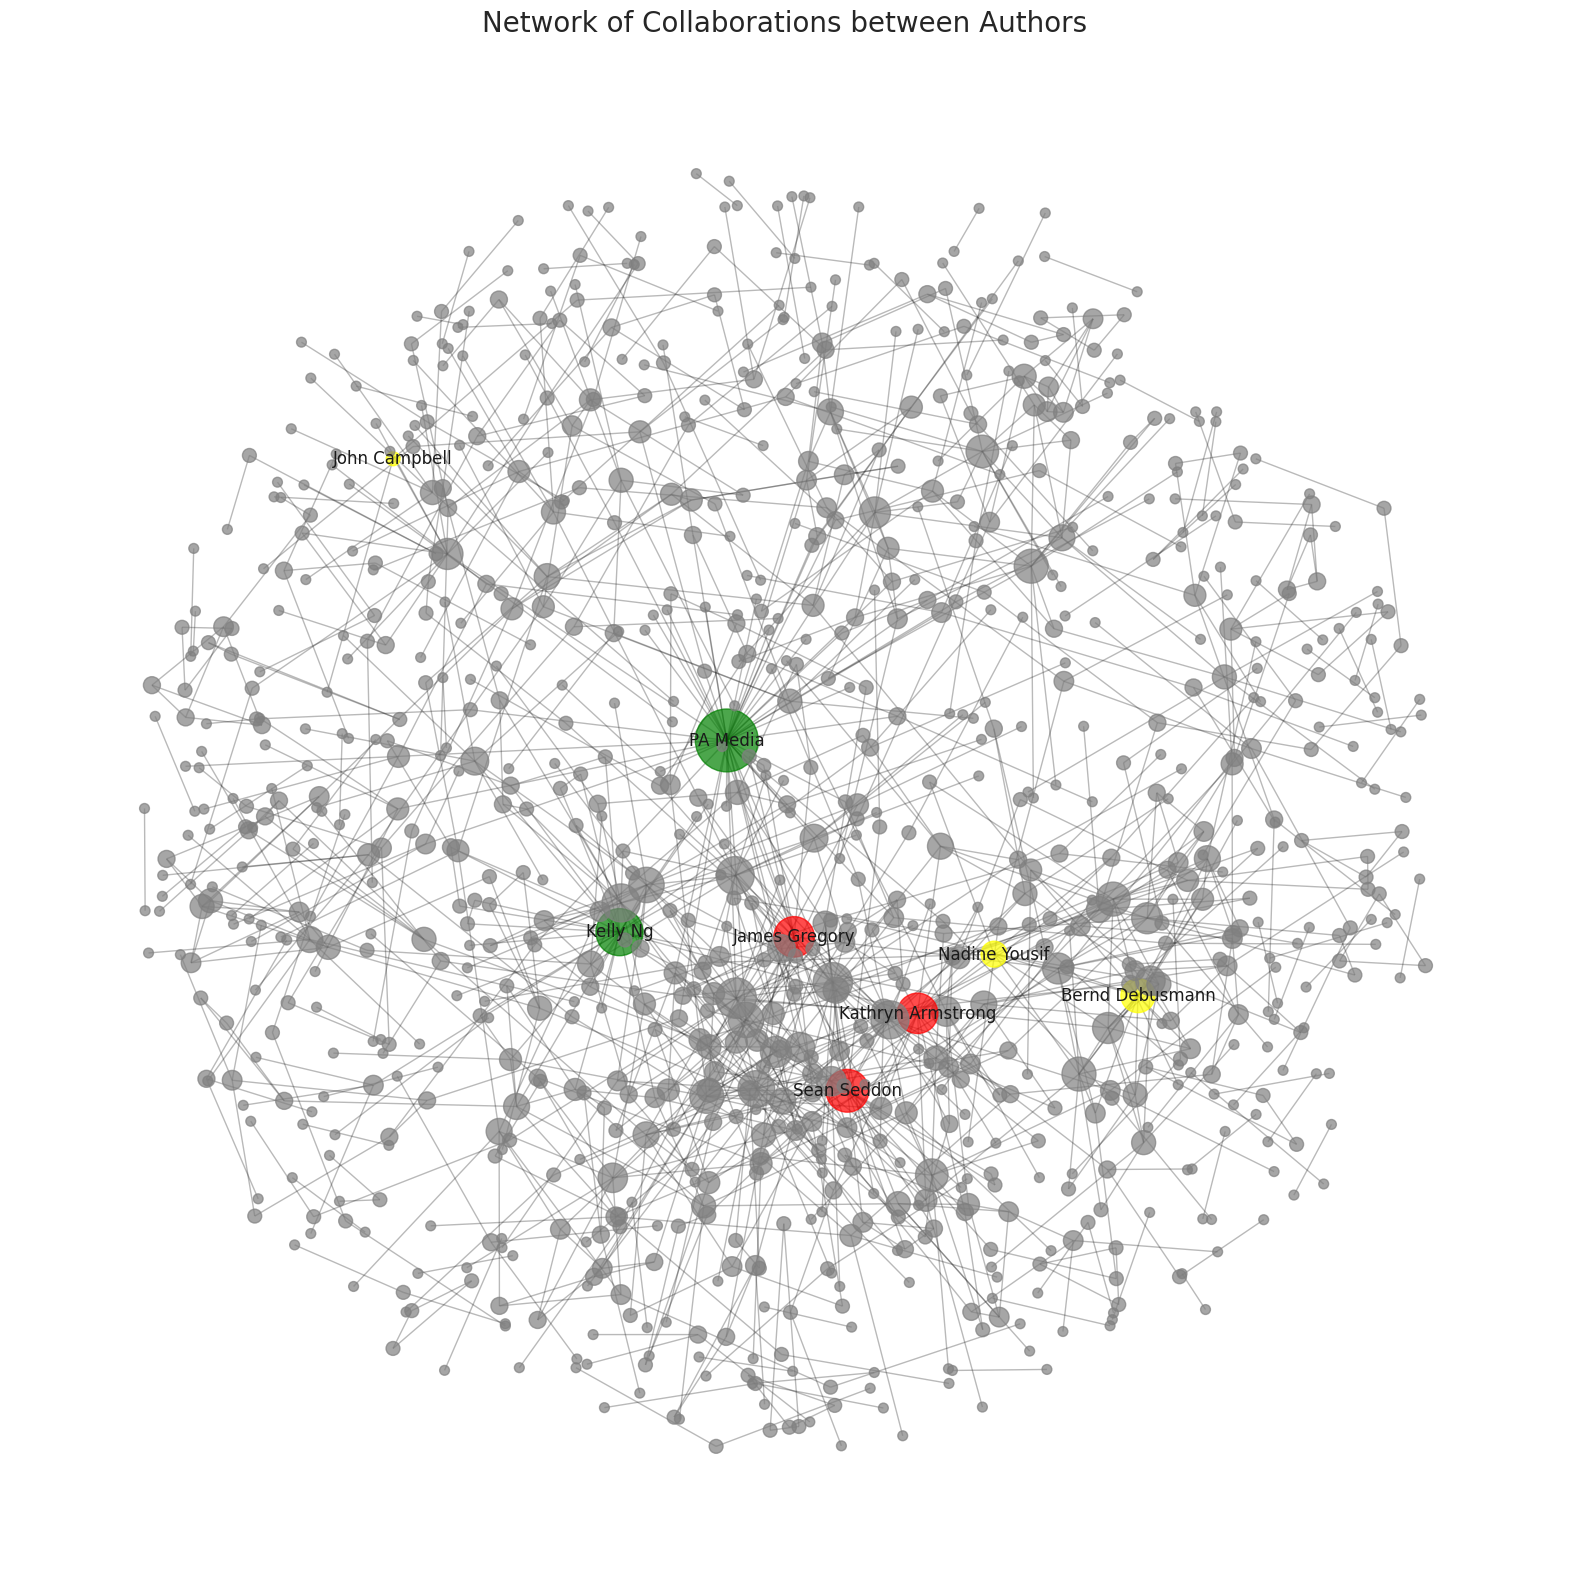

In [99]:
df['authors'] = df['authors'].apply(lambda record: [r for r in record if r not in ("N/A", "")])
df = df.dropna(subset=['authors'])

author_article_count = df.explode('authors')['authors'].value_counts()
top_authors_by_articles = author_article_count.head(5).index.tolist()

pairs = []
for authors in df['authors']:
    # from our arrays combine every 2 authors
    pairs.extend(itertools.combinations(authors, 2))

G = nx.Graph()
G.add_edges_from(pairs)

# remove lone wolves
isolated_nodes = list(nx.isolates(G))
G.remove_nodes_from(isolated_nodes)

node_degrees = dict(G.degree())

# retrieve authors with most collaborations
top_authors_by_degree = sorted(node_degrees, key=node_degrees.get, reverse=True)[:5]

node_sizes = [node_degrees[n] * 50 for n in G.nodes()]

node_colors = []
for node in G.nodes():
    
    if node in top_authors_by_articles and node in top_authors_by_degree:
        # Authors who are top in both categories
        node_colors.append('green')  
        
    elif node in top_authors_by_articles:
        # Top authors by number of articles
        node_colors.append('yellow')    
        
    elif node in top_authors_by_degree:
        # Top authors by degree
        node_colors.append('red')   
    else:
        node_colors.append('grey')

pos = nx.spring_layout(G, k=0.15, iterations=50)

plt.figure(figsize=(20, 20))
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.3, width=1)
nx.draw_networkx_labels(G, pos, {n: n if n in top_authors_by_degree or n in top_authors_by_articles else '' for n in G.nodes()}, font_size=12)

plt.title("Network of Collaborations between Authors", fontsize=20)
plt.axis('off')
plt.show()


From above graph we can conclude a number of things:
- PA Media and Kelly Ng are in the top publishers of articles from both point of views (Collaborations and articles), they probably work with others often and are not the kind to publish alone very much.
- John Campbell, Nadine Youssif and Bernd Debusmann are on the top from articles number point of view but here we can see that they are small collaborators. They are closer to lone wolves as they prefer to work alone. For Nadine Yousiif's case, this could be due to the fact that he is covering Israel-Gaza war topics mostly and needs to give frequent update that he has no time for collaborations.
- We can also see 3 other authors which do not belong to the top authors but are among the top contributors. This implicates that possibly, we do not have alot of authors that publishes often in collaboration as the process takes more time to produce articles in a group than working alone, resulting in these 3 authors not appearing amongst the top publishers due to the outnumbering of "lone wolves".